# Prediction for Berlin

## Summary writing is in README.md

In [1]:
import os
import sys
import warnings

import numpy as np

import pandas as pd
import statsmodels.formula.api as smf
from IPython.core.display import HTML
import seaborn as sns

warnings.filterwarnings("ignore")
from plotnine import ggplot, aes, geom_point, labs, scale_x_continuous, scale_y_continuous, theme_bw
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from mizani.formatters import percent_format

In [2]:
df = pd.read_csv('BerlinQ4.csv')
print(df.shape)         # (13984, 75)
df.head()              # Show first 3 rows as a sample

(13984, 75)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2084992,https://www.airbnb.com/rooms/2084992,20241221052002,2024-12-21,previous scrape,"Nice and cozy apartment in Kreuzberg, Graefekiez",Our cosy two room Apartment (70qm) in a vibrat...,"The apartment is situated on Fichtestrasse, wh...",https://a0.muscache.com/pictures/c4f2a8a8-34fa...,6302373,...,5.00,4.64,4.82,NaN,f,1,1,0,0,0.09
1,1123383729460847373,https://www.airbnb.com/rooms/1123383729460847373,20241221052002,2024-12-21,city scrape,Furnished room in well equipped serviced apart...,Room in an apartment available. Apartment has ...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,206488801,...,NaN,NaN,NaN,NaN,f,3,1,2,0,NaN
2,1205255838613758737,https://www.airbnb.com/rooms/1205255838613758737,20241221052002,2024-12-21,city scrape,Luxurous game room with private bath in X-Berg,Cozy private room in Berlin Mitte with private...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,50009901,...,4.97,4.94,4.94,01/Z/AZ/017416-24,f,1,0,1,0,9.53
3,8164759,https://www.airbnb.com/rooms/8164759,20241221052002,2024-12-21,previous scrape,Beautiful single-room studio,Experience the “real Berlin” in our small and ...,In the area you can find lots of affordable ba...,https://a0.muscache.com/pictures/103988560/a5d...,42115726,...,5.00,3.00,3.00,NaN,f,1,1,0,0,0.01
4,18836877,https://www.airbnb.com/rooms/18836877,20241221052002,2024-12-21,previous scrape,Unterkunft zentral in Berlin,"The accommodation has 3 rooms, however, is onl...",NaN,https://a0.muscache.com/pictures/452bf022-c9a9...,131184702,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN


## Cleaning the Data

In [3]:
# Drop rows where 'price' is NaN
df = df.dropna(subset=['price'])
print(df.shape)  # Now (8990, 75), after removing rows with missing price

(8990, 75)


In [4]:
# Drop columns with > 3000 missing values
cols_to_drop = ['calendar_updated', 'host_neighbourhood', 'neighborhood_overview', 'neighbourhood', 'host_about']
df = df.drop(columns=cols_to_drop)
print(df.shape)  # e.g., (8990, 70) after dropping high-missing columns

(8990, 70)


In [5]:
if 'review_scores_rating' in df.columns:
    df['flag_review_scores_rating'] = df['review_scores_rating'].isna().astype(int)
else:
    print("Column 'review_scores_rating' not found; skipping flag_review_scores_rating.")

In [6]:
if 'last_review' in df.columns:
    df['flag_days_since'] = df['last_review'].isna().astype(int)
else:
    print("Column 'last_review' not found; skipping flag_review_scores_rating.")

In [7]:

if 'last_review' in df.columns:
    df['flag_reviews_per_month'] = df['reviews_per_month'].isna().astype(int)
else:
    print("Column 'reviews_per_month' not found; skipping flag_review_scores_rating.")

In [8]:
import ast
# Parse the amenities string into a Python list for each listing
df['amenities_list'] = df['amenities'].apply(lambda x: ast.literal_eval(x))

# Define amenity groups and keywords for grouping
amenity_groups = {
    'internet': ['wifi', 'ethernet', 'wlan', 'internet'],
    'air_conditioning': ['air conditioning', 'air conditioner'],
    'heating': ['heating', 'fireplace'],
    'kitchen': ['kitchen', 'kitchenette', 'stove', 'oven', 'microwave', 'refrigerator', 'cooking basics'],
    'parking': ['parking'],
    'laundry': ['washer', 'laundromat', 'dryer'],
    'tv': ['tv'], 
    'elevator': ['elevator'],
    'pets': ['pet', 'dog', 'cat'],
    'family': ['child', 'children', 'crib', 'kid', 'high chair', 'stroller', 'baby'],
    'safety': ['smoke alarm', 'carbon monoxide', 'fire extinguisher', 'first aid']
}

# Create a dummy column for each amenity group
for group, keywords in amenity_groups.items():
    df[f'amenity_{group}'] = df['amenities_list'].apply(
        lambda amenities: 1 if any(any(k in amen.lower() for k in keywords) for amen in amenities) else 0
    )

# Drop the original amenities columns as we now have encoded dummies
df = df.drop(columns=['amenities', 'amenities_list'])

In [9]:
# Create dummy variables for neighbourhood_group_cleansed
neighborhood_dummies = pd.get_dummies(df['neighbourhood_group_cleansed'], 
                                        prefix='neighbourhood_group', 
                                        drop_first=True)
neighborhood_dummies = neighborhood_dummies.astype(int)

# Clean the column names: replace spaces and hyphens with underscores
neighborhood_dummies.columns = [col.replace(" ", "_").replace("-", "_") for col in neighborhood_dummies.columns]

# Merge the dummy columns into the main DataFrame and drop the original column
df = pd.concat([df, neighborhood_dummies], axis=1)

# Check the first few rows to confirm the new dummy columns
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,picture_url,host_id,host_url,...,neighbourhood_group_Lichtenberg,neighbourhood_group_Marzahn___Hellersdorf,neighbourhood_group_Mitte,neighbourhood_group_Neukölln,neighbourhood_group_Pankow,neighbourhood_group_Reinickendorf,neighbourhood_group_Spandau,neighbourhood_group_Steglitz___Zehlendorf,neighbourhood_group_Tempelhof___Schöneberg,neighbourhood_group_Treptow___Köpenick
1,1123383729460847373,https://www.airbnb.com/rooms/1123383729460847373,20241221052002,2024-12-21,city scrape,Furnished room in well equipped serviced apart...,Room in an apartment available. Apartment has ...,https://a0.muscache.com/pictures/hosting/Hosti...,206488801,https://www.airbnb.com/users/show/206488801,...,0,0,1,0,0,0,0,0,0,0
2,1205255838613758737,https://www.airbnb.com/rooms/1205255838613758737,20241221052002,2024-12-21,city scrape,Luxurous game room with private bath in X-Berg,Cozy private room in Berlin Mitte with private...,https://a0.muscache.com/pictures/hosting/Hosti...,50009901,https://www.airbnb.com/users/show/50009901,...,0,0,0,0,0,0,0,0,0,0
5,886772024913265656,https://www.airbnb.com/rooms/886772024913265656,20241221052002,2024-12-21,city scrape,Studio in the heart of Berlin,"Located in the heart of Berlin, this stylish a...",https://a0.muscache.com/pictures/miso/Hosting-...,12360,https://www.airbnb.com/users/show/12360,...,0,0,1,0,0,0,0,0,0,0
6,13761071,https://www.airbnb.com/rooms/13761071,20241221052002,2024-12-21,city scrape,Central flat near Alex with fiber optic Internet,This light and clean apartment is located in a...,https://a0.muscache.com/pictures/miso/Hosting-...,80675177,https://www.airbnb.com/users/show/80675177,...,0,0,1,0,0,0,0,0,0,0
9,949319254792501534,https://www.airbnb.com/rooms/949319254792501534,20241221052002,2024-12-21,city scrape,Silent-Spacious-Green-Apartment,"Kick back and relax in this calm, stylish spac...",https://a0.muscache.com/pictures/miso/Hosting-...,529489961,https://www.airbnb.com/users/show/529489961,...,0,0,0,0,0,0,0,0,0,1


In [10]:
# Fill missing values in beds, bathrooms, bedrooms with the mean of that column
for col in ['beds', 'bathrooms', 'bedrooms']:
    df[col] = df[col].fillna(df[col].mean())

In [11]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

In [12]:
df["price"] = pd.to_numeric(df["price"])

In [13]:
# Remove spaces and hyphens from all column names
df = df.rename(columns=lambda x: x.replace(" ", "_").replace("-", "_"))

# Also remove hyphens from the values in the 'neighbourhood_cleansed' column
df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].str.replace("-", "_")

## descriptive statistics

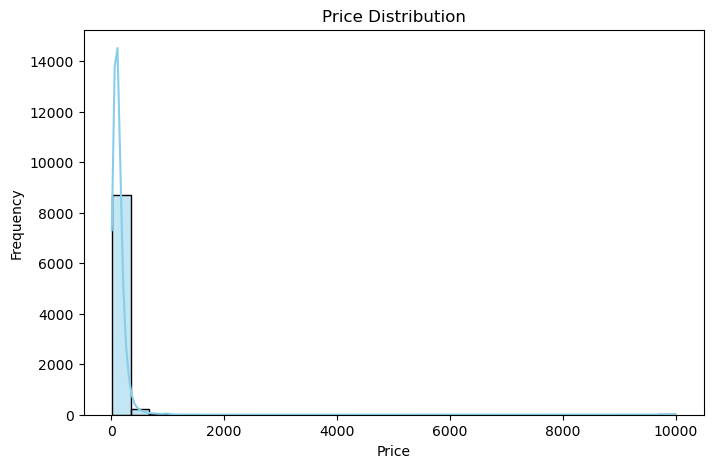

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=30, kde=True, color='skyblue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

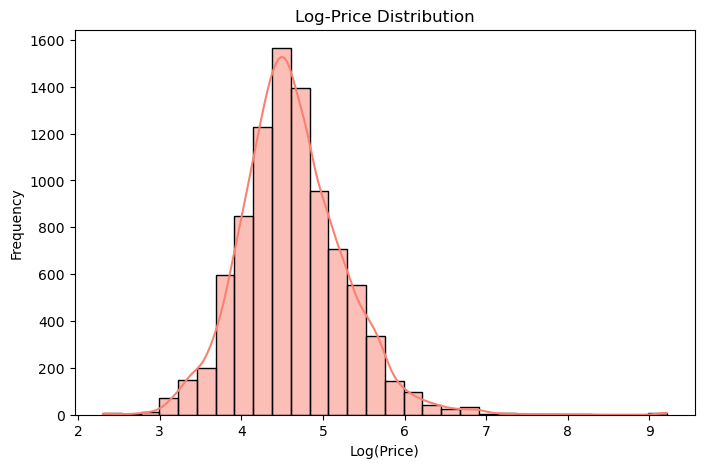

In [15]:
df['lnprice'] = np.log(df['price'])

plt.figure(figsize=(8, 5))
sns.histplot(df['lnprice'], bins=30, kde=True, color='salmon')
plt.title('Log-Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.show()

In [16]:
df = df[df['price'] <= 4000]

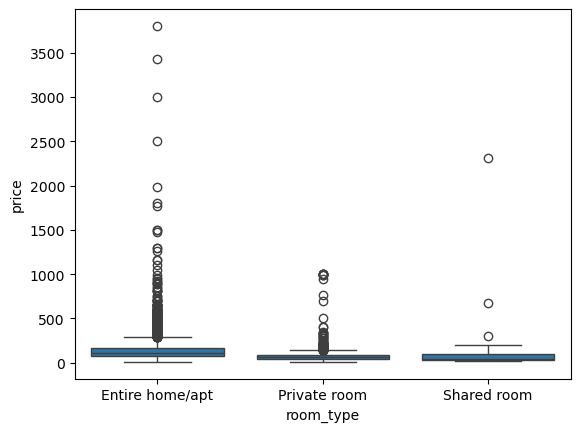

In [17]:
sns.boxplot(data = df, x = 'room_type', y = 'price', orient = 'v', order = ['Entire home/apt', 'Private room', 'Shared room'])
plt.show()


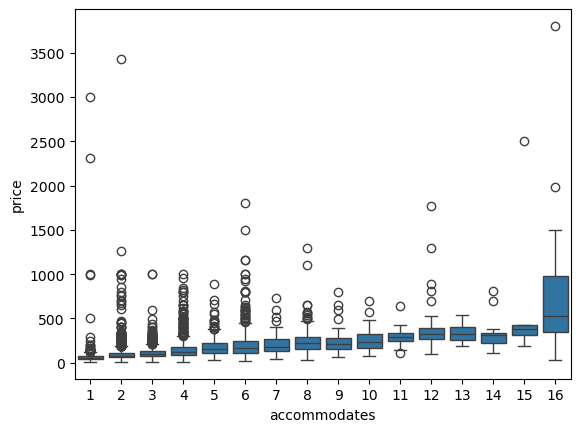

In [18]:
sns.boxplot(data = df, x = 'accommodates', y = 'price', orient = 'v')
plt.show()

In [19]:
all_property_types = sorted(df['property_type'].unique())
all_room_types = sorted(df['room_type'].unique())

# Convert the columns to categorical with these explicit levels
df['property_type'] = pd.Categorical(df['property_type'], categories=all_property_types)
df['room_type'] = pd.Categorical(df['room_type'], categories=all_room_types)

In [20]:
to_filter=df.isna().sum()
to_filter[to_filter>0].sort_values(ascending = False)

last_review                    2088
review_scores_rating           2088
review_scores_value            2088
review_scores_location         2088
review_scores_communication    2088
review_scores_checkin          2088
review_scores_cleanliness      2088
review_scores_accuracy         2088
reviews_per_month              2088
first_review                   2088
host_location                  1971
license                        1924
host_response_rate             1363
host_response_time             1363
host_acceptance_rate           1008
description                     367
host_is_superhost               113
has_availability                112
bathrooms_text                    6
dtype: int64

In [21]:
df.host_is_superhost = df.host_is_superhost.fillna('f')

In [22]:
df['host_is_superhost'] = df['host_is_superhost'].map({'f': 0, 't': 1})

In [23]:
# Factorize the host_response_time column (missing values are coded as -1)
codes, uniques = pd.factorize(df['host_response_time'])
df['host_response_time'] = codes

# Calculate the mean of the valid codes (excluding -1)
valid_mean = df.loc[df['host_response_time'] != -1, 'host_response_time'].mean()

# Replace missing values (coded as -1) with the computed mean
df.loc[df['host_response_time'] == -1, 'host_response_time'] = valid_mean

# Display the first few rows to verify the changes
df[['host_response_time', 'host_response_time']].head()

,host_response_time,host_response_time
1,0.0,0.0
2,0.0,0.0
5,0.0,0.0
6,0.0,0.0
9,1.0,1.0


In [24]:
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype(float)

In [25]:
df = df.fillna(df.mean(numeric_only=True))

In [26]:
df['host_has_profile_pic'] = df['host_has_profile_pic'].map({'f': 0, 't': 1})
df['host_identity_verified'] = df['host_identity_verified'].map({'f': 0, 't': 1})

In [27]:
df['last_review'] = pd.to_datetime(df['last_review'], format="%Y-%m-%d", errors='coerce')

# Find the latest date in the 'last_review' column
latest_date = df['last_review'].max()

# Create n_days_since: days between the latest date and each last_review date (min value becomes 0)
df['n_days_since'] = (latest_date - df['last_review']).dt.days

# Create n_accommodates2: 1 if 'accommodates' equals 2, else 0
df['n_accommodates2'] = (df['accommodates'] == 2).astype(int)

# Create n_days_since2: 1 if n_days_since equals 2, else 0
df['n_days_since2'] = (df['n_days_since'] == 2).astype(int)

# Create n_days_since3: 1 if n_days_since equals 3, else 0
df['n_days_since3'] = (df['n_days_since'] == 3).astype(int)

### Finding Interactions

In [28]:
basic_lev = (
    "accommodates",
    "beds",
    "property_type",
    "room_type",
    "n_days_since",
    "flag_days_since"
)
basic_add = ("bathrooms", "bedrooms", "host_is_superhost", "flag_reviews_per_month")
reviews = ("number_of_reviews", "review_scores_rating", "flag_review_scores_rating", "reviews_per_month")
host = ("host_response_time", "host_response_rate", "host_acceptance_rate", "host_has_profile_pic", "host_identity_verified")
poly_lev = ("n_accommodates2", "n_days_since2", "n_days_since3", "host_acceptance_rate")

In [29]:
def price_diff_by_variables(df, factor_var, dummy_var, factor_lab, dummy_lab):
    # Calculate statistics same way as before
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), 
        sd=("price", np.std), 
        size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1/2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()

    # Create the plot using seaborn
    # plt.figure(figsize=(10, 6))
    plt.figure()
    
    # Create bar plot
    ax = sns.barplot(
        data=stats,
        x=stats.columns[0],
        y='Mean',
        hue=stats.columns[1],
        palette=['indianred', 'steelblue'],
        ci=None
    )

    # Add error bars
    for i, group in enumerate(stats[stats.columns[1]].unique()):
        group_data = stats[stats[stats.columns[1]] == group]
        x = np.arange(len(group_data))
        
        # Adjust x positions for dodge effect
        if i == 1:
            x = x + 0.2
        else:
            x = x - 0.2
            
        plt.errorbar(
            x=x, 
            y=group_data['Mean'],
            yerr=[(group_data['Mean'] - group_data['Mean_l']), 
                  (group_data['Mean_u'] - group_data['Mean'])],
            fmt='none',
            color='black',
            capsize=3
        )

    # Customize the plot
    plt.xlabel(factor_lab)
    plt.ylabel('Mean Price')
    
    # Customize legend
    plt.legend(
        title=dummy_lab,
        bbox_to_anchor=(0.5, 1.15),
        loc='center',
        ncol=2,
        fontsize=10,
        title_fontsize=10
    )
    
    # Remove grid
    ax.grid(False)
    plt.show()
    
    return plt



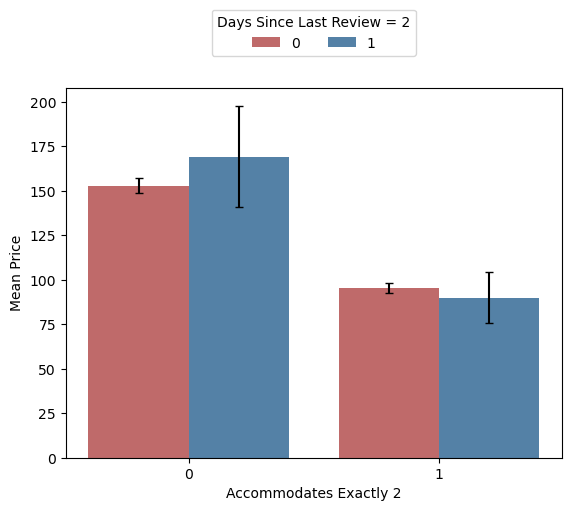

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [30]:
price_diff_by_variables(df, factor_var="n_accommodates2", dummy_var="n_days_since2", factor_lab="Accommodates Exactly 2", dummy_lab="Days Since Last Review = 2")

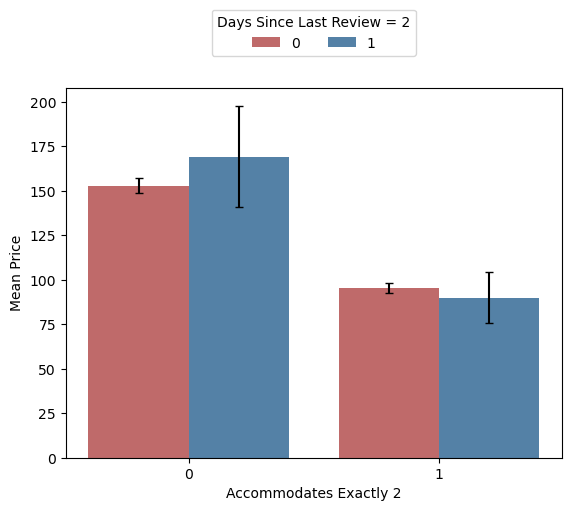

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [31]:
price_diff_by_variables(
    df=df,
    factor_var="n_accommodates2", 
    dummy_var="n_days_since2",
    factor_lab="Accommodates Exactly 2",
    dummy_lab="Days Since Last Review = 2"
)


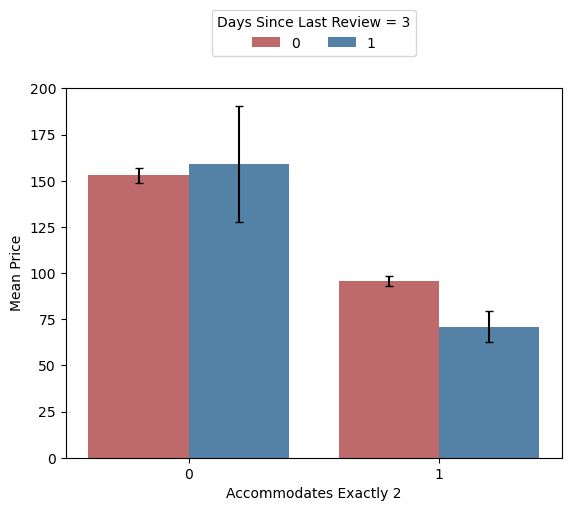

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [32]:
price_diff_by_variables(
    df=df,
    factor_var="n_accommodates2", 
    dummy_var="n_days_since3",
    factor_lab="Accommodates Exactly 2",
    dummy_lab="Days Since Last Review = 3"
)

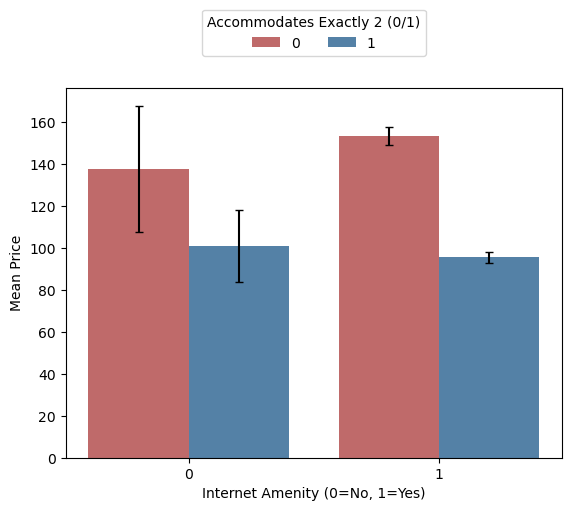

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [33]:
price_diff_by_variables(
    df=df,
    factor_var="amenity_internet",       # 0: No internet, 1: Internet available
    dummy_var="n_accommodates2",          # 0: Not exactly 2, 1: Exactly 2
    factor_lab="Internet Amenity (0=No, 1=Yes)",
    dummy_lab="Accommodates Exactly 2 (0/1)"
)


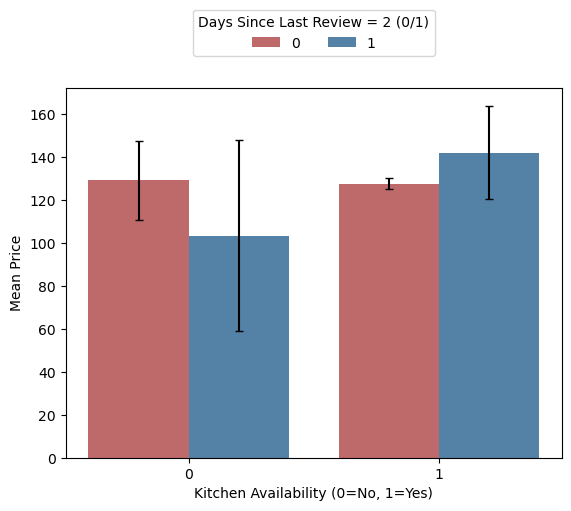

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [34]:
price_diff_by_variables(
    df=df,
    factor_var="amenity_kitchen",         # 0: No kitchen, 1: Kitchen available
    dummy_var="n_days_since2",              # 0: n_days_since is not 2, 1: n_days_since equals 2
    factor_lab="Kitchen Availability (0=No, 1=Yes)",
    dummy_lab="Days Since Last Review = 2 (0/1)"
)

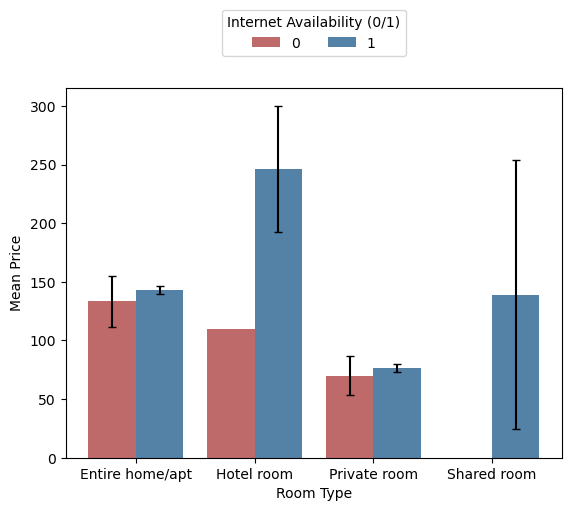

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [35]:
price_diff_by_variables(
    df=df,
    factor_var="room_type",              # Categorical variable: Room Type
    dummy_var="amenity_internet",        # Binary variable: Internet Availability (0 = No, 1 = Yes)
    factor_lab="Room Type",
    dummy_lab="Internet Availability (0/1)"
)

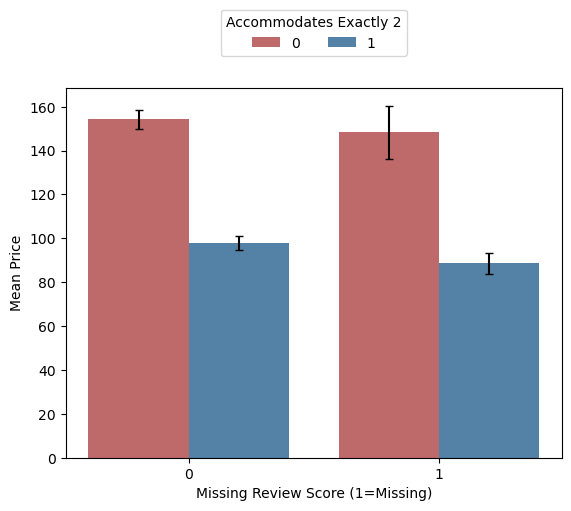

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [36]:
price_diff_by_variables(
    df=df,
    factor_var="flag_review_scores_rating", 
    dummy_var="n_accommodates2",
    factor_lab="Missing Review Score (1=Missing)",
    dummy_lab="Accommodates Exactly 2"
)

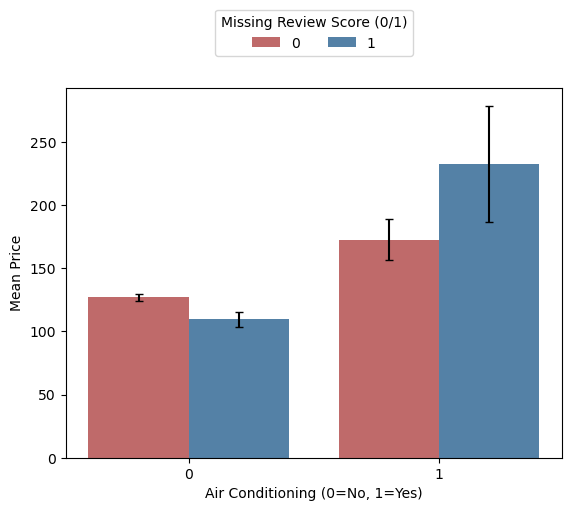

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [37]:
price_diff_by_variables(
    df=df,
    factor_var="amenity_air_conditioning",  # 0: No air conditioning, 1: Air conditioning available
    dummy_var="flag_review_scores_rating",    # 0: Review score available, 1: Review score missing
    factor_lab="Air Conditioning (0=No, 1=Yes)",
    dummy_lab="Missing Review Score (0/1)"
)

In [38]:
amenities = [col for col in df.columns if col.startswith("amenity_")]
print(amenities)

['amenity_internet', 'amenity_air_conditioning', 'amenity_heating', 'amenity_kitchen', 'amenity_parking', 'amenity_laundry', 'amenity_tv', 'amenity_elevator', 'amenity_pets', 'amenity_family', 'amenity_safety']


In [39]:
X1 = (
    "room_type*property_type",
    "room_type*amenity_family"
)

# X2: Interactions between property_type and selected amenity variables
X2 = (
    "amenity_air_conditioning*property_type",
    "amenity_pets*property_type"
)

# X3: A broad interaction between key categorical variables and all amenity variables.
# Since you do not have cancellation_policy, we use (property_type + room_type + bed_type)
X3 = "(property_type + room_type) * (" + " + ".join(amenities) + ")"

In [40]:
modellev1="~ accommodates"
modellev2="~"+"+".join(basic_lev)
modellev3="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)
modellev4="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(poly_lev)+"+"+"+".join(neighborhood_dummies)
modellev5="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(poly_lev)+"+"+"+".join(neighborhood_dummies)+"+"+"+".join(X1)
modellev6="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(poly_lev)+"+"+"+".join(neighborhood_dummies)+"+"+"+".join(X1)+"+"+"+".join(X2)
modellev7="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(poly_lev)+"+"+"+".join(neighborhood_dummies)+"+"+"+".join(X1)+"+"+"+".join(X2)+"+"+"+".join(amenities)
modellev8="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(poly_lev)+"+"+"+".join(neighborhood_dummies)+"+"+"+".join(X1)+"+"+"+".join(X2)+"+"+"+".join(amenities)+"+"+X3

In [41]:
smp_size = round(0.2 * df.shape[0])-1
smp_size

1795

## OLS prediction

In [42]:
np.random.seed(20250217)

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
df_train, df_holdout = train_test_split( df, train_size=0.7, random_state = 20250224)

In [45]:
df_train.shape

(6286, 99)

In [46]:
df_holdout.shape

(2695, 99)

In [47]:
n_folds=5

In [48]:
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import mse,rmse
k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

In [49]:
def cv_reg(formula, df, kfold, testdf, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(df):
        df_train, df_test = df.iloc[train_index, :], df.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data = df_train).fit()
        else:
            model = smf.ols(formula, data = df_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(df_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [df_train["price"], model.predict(df_train)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [df_test["price"], model.predict(df_test)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr["price"], rmse_tr["predicted"], axis=0)]
        rmse_list_test += [rmse(rmse_te["price"], rmse_te["predicted"], axis=0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [50]:
cv_list = []
for i in [
    modellev1,
    modellev2,
    modellev3,
    modellev4,
    modellev5,
    modellev6,
    modellev7,
    modellev8,
]:
    cv_list += [cv_reg("price" + i, df, k, "HC0")]

In [51]:
summarize_cv(cv_list).map('{:,.3f}'.format)

,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8
Fold1,123.845,108.872,104.167,103.667,103.239,101.973,101.749,92.756
Fold2,120.138,102.635,99.153,98.672,98.554,97.724,97.429,88.186
Fold3,109.752,90.804,86.420,85.758,85.387,83.881,83.376,79.416
Fold4,121.617,106.873,103.257,102.681,102.359,101.066,100.850,91.511
Fold5,107.089,103.893,100.730,100.250,100.073,99.211,98.897,91.405
Average,116.488,102.615,98.745,98.206,97.922,96.771,96.460,88.655


In [52]:
# RMSE training vs test graph

rmse_levels = {"nvars": [], "var": [], "value": []}
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Training")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse"]).mean())
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Test")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse_test"]).mean())
df_rmse_levels = pd.DataFrame.from_dict(rmse_levels)
df_rmse_levels["nvars2"] = df_rmse_levels["nvars"] + 1

In [53]:
df_rmse_levels

,nvars,var,value,nvars2
0,1,RMSE Training,116.488420,2
1,55,RMSE Training,102.615199,56
2,66,RMSE Training,98.745369,67
3,80,RMSE Training,98.205543,81
4,85,RMSE Training,97.922371,86
5,148,RMSE Training,96.770783,149
6,156,RMSE Training,96.460309,157
7,348,RMSE Training,88.654770,349
8,1,RMSE Test,113.740537,2
9,55,RMSE Test,103.003051,56


In [54]:
model2_train_rmse = pd.Series(cv_list[2]["rmse"]).mean()
model2_test_rmse = pd.Series(cv_list[2]["rmse_test"]).mean()

print("Model 3 RMSE Training: {:.3f}".format(model2_train_rmse))
print("Model 3 RMSE Test: {:.3f}".format(model2_test_rmse))

Model 3 RMSE Training: 98.745
Model 3 RMSE Test: 100.769


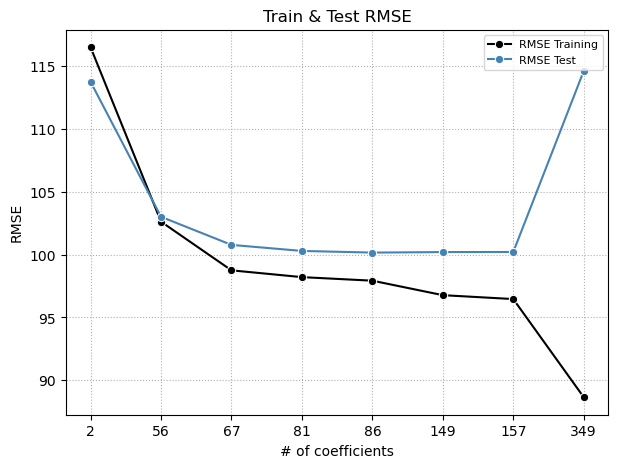

In [55]:
plt.figure(figsize=(7,5))
ax = sns.lineplot(
    x = [str(x) for x in df_rmse_levels['nvars2']], 
    y = df_rmse_levels['value'], 
    hue = df_rmse_levels['var'], marker = 'o',
    palette = ['k', 'steelblue']
)
ax.set_title('Train & Test RMSE')
ax.set_ylabel('RMSE')
ax.set_xlabel('# of coefficients')
ax.legend(fontsize = 8, title = None)
ax.grid(linestyle = ':')
plt.show();

## Lasso prediction

In [56]:
vars_model_8 = modellev8

In [57]:
from sklearn.linear_model import Lasso
import patsy
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
y, X = patsy.dmatrices("price" + vars_model_8, df)

In [58]:
y

DesignMatrix with shape (6893, 1)
  price
     95
     59
    224
    154
    163
     73
    130
    181
     82
     38
    180
    159
     40
    196
    210
     93
    300
    145
    263
     82
    100
    297
    200
    170
    209
     87
     62
     50
     56
     50
  [6863 rows omitted]
  Terms:
    'price' (column 0)
  (to view full data, use np.asarray(this_obj))

In [59]:
X.shape

(6893, 919)

In [60]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=smp_size, random_state=10
)

lambdas = [i/100 for i in range(5, 100,5)]

train_r_squared = np.zeros(len(lambdas))
test_r_squared = np.zeros(len(lambdas))

pred_num = X.shape[1]
coeff_a = np.zeros((len(lambdas), pred_num))

In [61]:
lambdas

[0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95]

In [62]:
train_r_squared

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [63]:
X.shape[1]

919

In [64]:
import datetime

In [65]:
from sklearn.model_selection import cross_val_score

for ind, i in enumerate(lambdas):
    print(f"Run: {str(ind).rjust(2)}, lambda: {i:.2f}, start: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    reg = Lasso(alpha = i, random_state= 20250217) # In Python, Lasso's lambda is called alpha. Why?
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=cv, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

Run:  0, lambda: 0.05, start: 2025-03-03 03:14:11
Run:  1, lambda: 0.10, start: 2025-03-03 03:14:31
Run:  2, lambda: 0.15, start: 2025-03-03 03:14:52
Run:  3, lambda: 0.20, start: 2025-03-03 03:15:09
Run:  4, lambda: 0.25, start: 2025-03-03 03:15:24
Run:  5, lambda: 0.30, start: 2025-03-03 03:15:39
Run:  6, lambda: 0.35, start: 2025-03-03 03:15:51
Run:  7, lambda: 0.40, start: 2025-03-03 03:16:03
Run:  8, lambda: 0.45, start: 2025-03-03 03:16:14
Run:  9, lambda: 0.50, start: 2025-03-03 03:16:24
Run: 10, lambda: 0.55, start: 2025-03-03 03:16:37
Run: 11, lambda: 0.60, start: 2025-03-03 03:16:49
Run: 12, lambda: 0.65, start: 2025-03-03 03:17:01
Run: 13, lambda: 0.70, start: 2025-03-03 03:17:12
Run: 14, lambda: 0.75, start: 2025-03-03 03:17:23
Run: 15, lambda: 0.80, start: 2025-03-03 03:17:33
Run: 16, lambda: 0.85, start: 2025-03-03 03:17:42
Run: 17, lambda: 0.90, start: 2025-03-03 03:17:51
Run: 18, lambda: 0.95, start: 2025-03-03 03:17:59


In [66]:
results

array([0.40094702, 0.27477707, 0.36911663, 0.08013875, 0.0093834 ])

In [67]:
r_squared_df = (
    pd.DataFrame(
        {
            "$R^2$ Test set": test_r_squared,
            "$R^2$ Training set": train_r_squared,
            "lambda": lambdas,
        }
    )
    .melt(id_vars=["lambda"])
)

In [68]:
r_squared_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lambda    38 non-null     float64
 1   variable  38 non-null     object 
 2   value     38 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.0+ KB


In [69]:
r_squared_df["variable"] = r_squared_df["variable"].astype("category").cat.reorder_categories(
    ["$R^2$ Training set", "$R^2$ Test set"]
)

In [70]:
r_squared_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lambda    38 non-null     float64 
 1   variable  38 non-null     category
 2   value     38 non-null     float64 
dtypes: category(1), float64(2)
memory usage: 902.0 bytes


In [71]:
r_squared_df

,lambda,variable,value
0,0.05,$R^2$ Test set,0.342244
1,0.10,$R^2$ Test set,0.346282
2,0.15,$R^2$ Test set,0.346556
3,0.20,$R^2$ Test set,0.347542
4,0.25,$R^2$ Test set,0.348082
5,0.30,$R^2$ Test set,0.348367
6,0.35,$R^2$ Test set,0.348609
7,0.40,$R^2$ Test set,0.348677
8,0.45,$R^2$ Test set,0.348581
9,0.50,$R^2$ Test set,0.348532


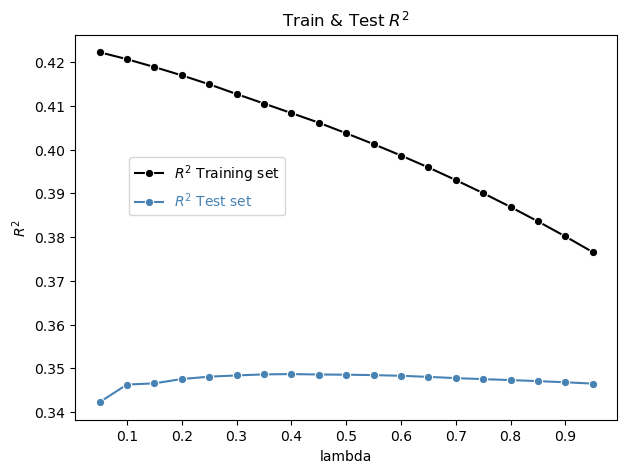

In [72]:
plt.figure(figsize=(7,5))
ax = sns.lineplot(
    data = r_squared_df, 
    x = 'lambda', y = 'value', hue = 'variable', 
    palette = ['k', 'steelblue'],
    marker = 'o'
)
ax.set_title('Train & Test $R^2$')
ax.set_ylabel('$R^2$')
ax.set_xlabel('lambda')
ax.set_xticks(lambdas[1::2])
ax.legend(fontsize = 10, title = None, labelcolor = ['k', 'steelblue'], loc='upper right', bbox_to_anchor=(0.4, 0.7))
plt.show();

In [73]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    34.867699
lambda        0.400000
Name: 7, dtype: float64

In [74]:
reg_best = Lasso(alpha = df_lam.loc[df_lam['R_squared'].idxmax()]['lambda'])
reg_best.fit(X_train, y_train)

Lasso(alpha=0.4)

In [75]:
y_train_pred = reg_best.predict(X_train)

In [76]:
from sklearn.metrics import mean_squared_error

In [77]:
rmse_Lasso_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training RMSE: {rmse_Lasso_train:.3f}")

Training RMSE: 90.452


In [78]:
y_test_pred = reg_best.predict(X_test)

In [79]:
rmse_Lasso_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE: {rmse_Lasso_test:.3f}")

Test RMSE: 104.393


In [80]:
reg_best.coef_[reg_best.coef_>0]

array([1.15512559e+02, 2.51512239e-01, 1.14064542e-04, 1.07577697e-01,
       2.18166573e-04, 6.74023919e-05, 2.53571324e+00, 7.69572101e+00,
       4.48983968e+01, 7.58389598e+00, 1.01097547e+01, 1.42157984e+01,
       4.08959901e+00, 7.52332387e+00, 1.25700506e+00, 1.75318048e+00,
       1.58849119e+00, 7.76625179e-01, 2.06214941e+00, 4.55920375e+00,
       1.68359314e+00, 7.20789142e-01, 1.89584948e+00, 1.62454647e-01,
       2.13850159e-01, 1.60916914e+00, 2.58584727e+00, 2.67263079e-02,
       8.87449758e+00, 2.45849469e-06, 4.13625260e+00, 4.30367451e-01,
       6.37303951e+00, 3.73836907e-02, 4.35856783e-01, 2.38389313e+00,
       4.06554809e-01, 3.44693322e+00, 6.85286340e+00, 8.33471210e-01,
       1.80076204e-02, 3.45913821e+00, 6.26878685e+00, 4.39062485e+00,
       1.07686789e+00, 2.12589625e+00, 5.91573136e-01, 6.47064804e-01,
       1.72222033e+00, 1.67864171e-01, 6.22177662e-01, 7.12016895e+00,
       8.37403156e-02, 3.25904967e+00, 5.60018839e+01, 5.25736441e+00,
      

In [81]:
print(reg_best.coef_)

[ 0.00000000e+00 -9.60870842e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  1.15512559e+02  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.08386800e-02  0.00000000e+00  2.51512239e-01  0.00000000e+00
  1.14064542e-04  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -2.83705170e-02 -2.00662680e-02  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.99210192e-02 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.47840262e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.55866297e-01
  0.00000000e+00  1.07577697e-01 -3.10245662e+00 -2.06145302e+00
  0.00000000e+00  0.00000

In [82]:
reg_best.get_params()

{'alpha': 0.4,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

## LASSO using `GridSearch`

In [83]:
from sklearn.metrics import mean_squared_error

print(f'{mean_squared_error(y_test, reg_best.predict(X_test)):,.2f}')

10,897.88


In [84]:
y,  X = patsy.dmatrices('price'+vars_model_8, df)

In [85]:
vars_model_8

'~accommodates+beds+property_type+room_type+n_days_since+flag_days_since+bathrooms+bedrooms+host_is_superhost+flag_reviews_per_month+number_of_reviews+review_scores_rating+flag_review_scores_rating+reviews_per_month+host_response_time+host_response_rate+host_acceptance_rate+host_has_profile_pic+host_identity_verified+n_accommodates2+n_days_since2+n_days_since3+host_acceptance_rate+neighbourhood_group_Friedrichshain_Kreuzberg+neighbourhood_group_Lichtenberg+neighbourhood_group_Marzahn___Hellersdorf+neighbourhood_group_Mitte+neighbourhood_group_Neukölln+neighbourhood_group_Pankow+neighbourhood_group_Reinickendorf+neighbourhood_group_Spandau+neighbourhood_group_Steglitz___Zehlendorf+neighbourhood_group_Tempelhof___Schöneberg+neighbourhood_group_Treptow___Köpenick+room_type*property_type+room_type*amenity_family+amenity_air_conditioning*property_type+amenity_pets*property_type+amenity_internet+amenity_air_conditioning+amenity_heating+amenity_kitchen+amenity_parking+amenity_laundry+amenity_

In [86]:
X.shape

(6893, 919)

In [87]:
from sklearn.model_selection import GridSearchCV

In [88]:
%%time

# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 20250217)
# define grid
grid = dict()
grid["alpha"] = np.arange(0.05, 1, 0.05)
# define search
search = GridSearchCV(model, grid, scoring="neg_root_mean_squared_error", cv = cv, verbose= 3) # control your output with the 'verbose' option
# perform the search
results = search.fit(X, y)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV 1/5] END .....................alpha=0.05;, score=-124.086 total time=   1.6s
[CV 2/5] END ......................alpha=0.05;, score=-96.162 total time=   3.1s
[CV 3/5] END .....................alpha=0.05;, score=-123.470 total time=   2.4s
[CV 4/5] END ......................alpha=0.05;, score=-72.039 total time=   3.2s
[CV 5/5] END .....................alpha=0.05;, score=-100.507 total time=   2.3s
[CV 1/5] END ......................alpha=0.1;, score=-123.579 total time=   0.9s
[CV 2/5] END .......................alpha=0.1;, score=-91.262 total time=   2.5s
[CV 3/5] END ......................alpha=0.1;, score=-121.771 total time=   1.5s
[CV 4/5] END .......................alpha=0.1;, score=-69.758 total time=   1.7s
[CV 5/5] END .......................alpha=0.1;, score=-90.119 total time=   2.2s
[CV 1/5] END ......alpha=0.15000000000000002;, score=-123.065 total time=   0.8s
[CV 2/5] END .......alpha=0.15000000000000002;, 

In [89]:
print(f'RMSE: {(results.best_score_ * -1):,.3f}')

RMSE: 98.207


In [90]:
results.cv_results_['rank_test_score']

array([19, 18, 10,  4,  2,  1,  3,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15,
       16, 17], dtype=int32)

In [91]:
grid

{'alpha': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])}

In [92]:
results.best_estimator_

Lasso(alpha=0.3)

In [93]:
model3_level = smf.ols('price'+modellev3, data=df_train).fit(cov_type='HC0')
model7_level = smf.ols('price'+modellev7, data=df_train).fit(cov_type='HC0')

In [94]:
# look at holdout RMSE
model7_level_work_predictions = pd.concat(
    [df_train["price"], model7_level.predict(df_train)],
    axis=1,
    keys=["price", "predicted"],
)

In [95]:
model7_level_work_predictions.tail()

,price,predicted
165,129.0,141.044749
1239,65.0,150.167880
8259,108.0,NaN
6368,90.0,63.491376
315,139.0,117.500946


In [96]:
model7_level_work_predictions = model7_level_work_predictions[~model7_level_work_predictions.isna().any(axis=1)]
model7_level_work_rmse = rmse(model7_level_work_predictions["price"], model7_level_work_predictions["predicted"], axis=0)

In [97]:
model7_level_work_rmse

104.90978441067853

In [98]:
model7_level_holdout_predictions = pd.concat(
    [df_holdout["price"], model7_level.predict(df_holdout)],
    axis=1,
    keys=["price", "predicted"],
)
model7_level_holdout_predictions = model7_level_holdout_predictions[~model7_level_holdout_predictions.isna().any(axis=1)]
model7_level_holdout_rmse = rmse(model7_level_holdout_predictions["price"], model7_level_holdout_predictions["predicted"], axis=0)
print(
    f"RMSE work:{round(model7_level_work_rmse,2)}",
    "\t",
    f"RMSE holdout:{model7_level_holdout_rmse:.2f}",
)

RMSE work:104.91 	 RMSE holdout:80.26


In [99]:
Ylev=df_holdout['price']
"""meanY=Ylev.mean()
sdY=Ylev.std()
meanY_m2SE = meanY -1.96 * sdY
meanY_p2SE = meanY + 1.96 * sdY
Y5p=Ylev.quantile(.05)
Y95p=Ylev.quantile(.95)"""

'meanY=Ylev.mean()\nsdY=Ylev.std()\nmeanY_m2SE = meanY -1.96 * sdY\nmeanY_p2SE = meanY + 1.96 * sdY\nY5p=Ylev.quantile(.05)\nY95p=Ylev.quantile(.95)'

In [100]:
model7_level.get_prediction(df_holdout).summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,119.560698,6.639043,106.548413,132.572982,-89.881040,329.002435
1,121.130258,5.457443,110.433866,131.826650,-88.180360,330.440875
2,143.267680,13.388573,117.026558,169.508802,-67.410079,353.945439
3,90.296536,7.444473,75.705637,104.887436,-119.249201,299.842274
4,129.619338,27.701212,75.325961,183.912715,-86.353560,345.592236
...,...,...,...,...,...,...
2078,147.786052,6.438779,135.166278,160.405826,-61.631666,357.203770
2079,151.063577,21.345806,109.226566,192.900588,-62.119108,364.246263
2080,74.933174,15.227301,45.088213,104.778135,-136.223742,286.090091
2081,120.013128,11.247552,97.968332,142.057924,-90.183196,330.209452


In [101]:
# Create df frame with the real and predicted values
df_diagnostic = model7_level.get_prediction(df_holdout).summary_frame(alpha=0.05)

df_ = pd.concat(
    [df_holdout["price"], model7_level.predict(df_holdout)],
    axis=1,
    keys=["price", "predicted"],
)

In [102]:
df_.isna().sum()

price          0
predicted    612
dtype: int64

In [103]:
df_ = df_[~df_.isna().any(axis=1)].reset_index(drop=True)
df_diagnostic["Ylev"] = df_["price"]

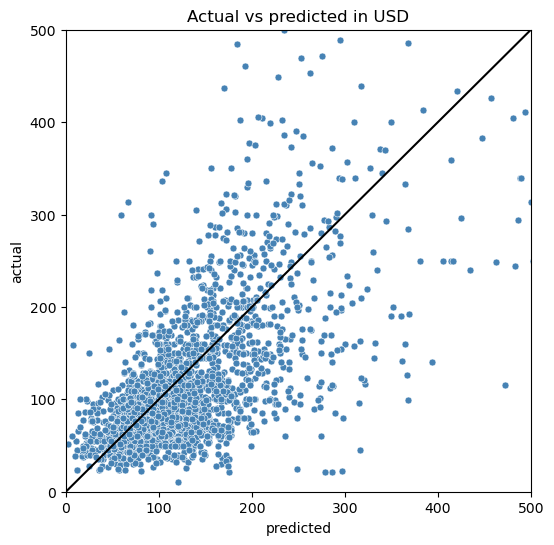

In [104]:
x = np.linspace(0, 500, df_diagnostic.shape[0])

plt.figure(figsize = (6,6))
ax = sns.scatterplot(
    data=df_diagnostic, x="mean", y="Ylev",
    s = 25, color = 'steelblue'
)
plt.plot(x,x, color = 'k')
ax.set_xlim(0,500)
ax.set_ylim(0,500)
ax.set_ylabel('actual')
ax.set_xlabel('predicted')
ax.set_title('Actual vs predicted in USD')
plt.show()

In [105]:
dt = model7_level.get_prediction(df_holdout).summary_frame(alpha=0.2)
df_extra = pd.concat(
    [
        df_holdout["price"],
        df_holdout["accommodates"],
        model7_level.predict(df_holdout),
    ],
    axis=1,
    keys=["price", "accommodates", "predicted"],
)
df_extra = df_extra[~df_extra.isna().any(axis=1)].reset_index(drop=True)
dt["accommodates"] = df_extra["accommodates"]
dt["Ylev"] = df_extra["price"]
dt["elev"] = dt["Ylev"] - dt["mean"]

In [106]:
df_diagnostic = model7_level.get_prediction(df_holdout).summary_frame(alpha=0.2)
df_ = pd.concat(
    [
        df_holdout["price"],
        df_holdout["accommodates"],
        model7_level.predict(df_holdout),
    ],
    axis=1,
    keys=["price", "accommodates", "predicted"],
)
df_ = df_[~df_.isna().any(axis=1)].reset_index(drop=True)
df_diagnostic["accommodates"] = df_["accommodates"]
df_diagnostic["Ylev"] = df_["price"]
df_diagnostic["elev"] = df_diagnostic["Ylev"] - df_diagnostic["mean"]

In [107]:
predictionlev_holdout_summary = df_diagnostic.groupby(by=["accommodates"]).mean().reset_index()

In [108]:
predictionlev_holdout_summary

,accommodates,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,Ylev,elev
0,1,58.442200,16.119318,37.784463,79.099937,-80.277220,197.161620,65.811321,7.369121
1,2,100.516411,14.701339,81.675887,119.356935,-38.132625,239.165448,96.374002,-4.142409
2,3,115.435136,15.160942,96.005607,134.864664,-23.288265,254.158536,111.758065,-3.677071
3,4,149.496809,16.133938,128.820335,170.173283,9.831918,289.161700,143.161209,-6.335600
4,5,187.115284,17.226169,165.039061,209.191508,47.429439,326.801130,178.596774,-8.518510
5,6,224.108504,23.740737,193.683526,254.533482,79.938601,368.278407,201.442029,-22.666475
6,7,221.156044,16.082879,200.545005,241.767082,82.613815,359.698273,207.909091,-13.246953
7,8,258.877052,18.595505,235.045954,282.708151,119.715097,398.039008,238.340426,-20.536627
8,9,277.587614,20.212753,251.683929,303.491299,138.037371,417.137858,206.555556,-71.032059
9,10,343.937254,29.549922,306.067506,381.807002,201.048067,486.826441,288.700000,-55.237254


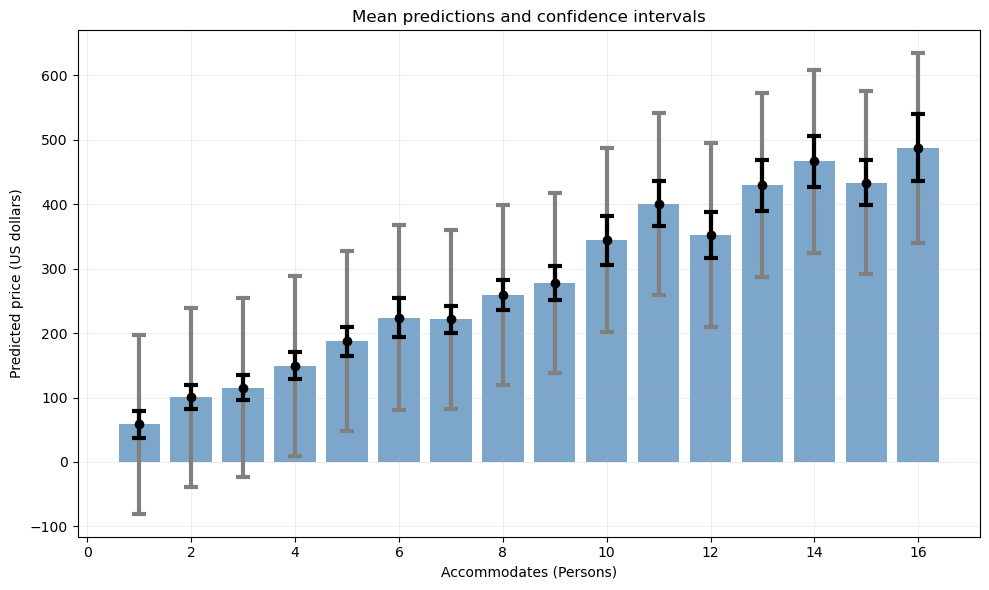

In [109]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for mean values
ax.bar(predictionlev_holdout_summary['accommodates'],
       predictionlev_holdout_summary['mean'],
       color='steelblue',
       alpha=0.7)

# Plot error bars for observations
ax.errorbar(predictionlev_holdout_summary['accommodates'],
            predictionlev_holdout_summary['mean'],
            yerr=[predictionlev_holdout_summary['mean'] - predictionlev_holdout_summary['obs_ci_lower'],
                  predictionlev_holdout_summary['obs_ci_upper'] - predictionlev_holdout_summary['mean']],
            fmt='none',
            color='grey',
            capsize=5,
            capthick=3,
            elinewidth=3)

# Plot error bars for means
ax.errorbar(predictionlev_holdout_summary['accommodates'],
            predictionlev_holdout_summary['mean'],
            yerr=[predictionlev_holdout_summary['mean'] - predictionlev_holdout_summary['mean_ci_lower'],
                  predictionlev_holdout_summary['mean_ci_upper'] - predictionlev_holdout_summary['mean']],
            fmt='bo',
            color='k',
            capsize=5,
            capthick=3,
            elinewidth=3)

# Customize axes and labels
ax.set_xlabel('Accommodates (Persons)')
ax.set_ylabel('Predicted price (US dollars)')
ax.set_title('Mean predictions and confidence intervals')

# Set style similar to theme_bw()
ax.grid(True, linestyle='-', alpha=0.2)
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_color('black')

# Adjust layout
plt.tight_layout()

# Return the plot


## Random Forest

In [110]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
from patsy import dmatrices, dmatrix
import matplotlib.ticker as mtick

In [111]:
df.price.describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).map('{:,.1f}'.format)

count    8,981.0
mean       127.8
std        130.9
min         10.0
1%          26.0
10%         49.0
25%         68.0
50%         97.0
75%        149.0
90%        230.0
99%        581.4
max      3,800.0
Name: price, dtype: object

In [112]:
df_train.shape, df_holdout.shape

((6286, 99), (2695, 99))

In [113]:
to_filter=df.isna().sum()
to_filter[to_filter>0].sort_values(ascending = False)

first_review        2088
last_review         2088
n_days_since        2088
host_location       1971
license             1924
description          367
has_availability     112
bathrooms_text         6
dtype: int64

In [114]:
# basic variables inc neighbourhood
basic_vars = [
    "accommodates",
    "beds",
    "n_days_since",
    "property_type",
    "room_type",
    "bathrooms",
    "bedrooms",
    "neighbourhood_cleansed",
]

# reviews
reviews = [
    "number_of_reviews",
    "flag_reviews_per_month",
    "review_scores_rating",
    "flag_review_scores_rating",
]

host = [
    "host_response_time", 
    "host_response_rate",
    "host_acceptance_rate",
    "host_has_profile_pic", 
    "host_identity_verified"]

# dummy variables
amenities = [col for col in df if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "accommodates:property_type",
    "room_type:property_type",
    "room_type:amenity_family",
    "amenity_air_conditioning:property_type",
    "amenity_pets:property_type"
]
# with boroughs
X2 = [
    "property_type:neighbourhood_cleansed",
    "room_type:neighbourhood_cleansed",
    "accommodates:neighbourhood_cleansed",
]

In [115]:
categorical_columns = [
    'property_type',
    'room_type',
    'neighbourhood_cleansed'
]

In [116]:
print(df['neighbourhood_group_cleansed'].unique())

['Mitte' 'Friedrichshain-Kreuzberg' 'Treptow - Köpenick' 'Neukölln'
 'Pankow' 'Tempelhof - Schöneberg' 'Charlottenburg-Wilm.'
 'Steglitz - Zehlendorf' 'Spandau' 'Lichtenberg' 'Reinickendorf'
 'Marzahn - Hellersdorf']


In [117]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + host + amenities
predictors_E = basic_vars + reviews + host + amenities + X1 + X2

In [118]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), df_train, return_type='dataframe')
print("Training design matrix shape:", X.shape)  # e.g., (4810, 209)

# Build holdout design matrices from df_holdout
y_h, X_h = dmatrices("price ~ " + " + ".join(predictors_2), df_holdout, return_type='dataframe')
print("Holdout design matrix shape (before reindexing):", X_h.shape)  # e.g., (2083, 204)

# Convert the holdout design matrix into a DataFrame with the expected column names from training
X_h_df = pd.DataFrame(X_h, columns=X.design_info.column_names)

# Reindex the holdout DataFrame to ensure it has all columns from the training matrix, filling missing columns with 0
X_h_df = X_h_df.reindex(columns=X.columns, fill_value=0)
print("Holdout design matrix shape (after reindexing):", X_h_df.shape)  # Now (2083, 209)

Training design matrix shape: (4810, 209)
Holdout design matrix shape (before reindexing): (2083, 204)
Holdout design matrix shape (after reindexing): (2083, 209)


In [119]:
X.design_info.column_names

['Intercept',
 'property_type[T.Camper/RV]',
 'property_type[T.Campsite]',
 'property_type[T.Casa particular]',
 'property_type[T.Dome]',
 'property_type[T.Entire bungalow]',
 'property_type[T.Entire cabin]',
 'property_type[T.Entire chalet]',
 'property_type[T.Entire condo]',
 'property_type[T.Entire cottage]',
 'property_type[T.Entire guest suite]',
 'property_type[T.Entire guesthouse]',
 'property_type[T.Entire home]',
 'property_type[T.Entire loft]',
 'property_type[T.Entire place]',
 'property_type[T.Entire rental unit]',
 'property_type[T.Entire serviced apartment]',
 'property_type[T.Entire townhouse]',
 'property_type[T.Entire vacation home]',
 'property_type[T.Entire villa]',
 'property_type[T.Farm stay]',
 'property_type[T.Houseboat]',
 'property_type[T.Private room]',
 'property_type[T.Private room in bed and breakfast]',
 'property_type[T.Private room in boat]',
 'property_type[T.Private room in bungalow]',
 'property_type[T.Private room in casa particular]',
 'property_typ

In [120]:
X.shape

(4810, 209)

In [121]:
import math

In [122]:
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 14.46.


In [123]:
rfr = RandomForestRegressor(random_state = 20250224)

In [124]:
tune_grid = {"max_features": [11, 13, 15, 17], "min_samples_leaf": [5, 10, 15]}
tune_grid

{'max_features': [11, 13, 15, 17], 'min_samples_leaf': [5, 10, 15]}

In [125]:
rf_random = GridSearchCV(
    estimator = rfr,
    param_grid = tune_grid,
    cv = 5,
    scoring = "neg_root_mean_squared_error",
    verbose = 3,
)

In [126]:
rf_model = rf_random.fit(X, y.values.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=11, min_samples_leaf=5;, score=-154.897 total time=   0.2s
[CV 2/5] END max_features=11, min_samples_leaf=5;, score=-77.407 total time=   0.2s
[CV 3/5] END max_features=11, min_samples_leaf=5;, score=-87.680 total time=   0.2s
[CV 4/5] END max_features=11, min_samples_leaf=5;, score=-100.629 total time=   0.2s
[CV 5/5] END max_features=11, min_samples_leaf=5;, score=-117.972 total time=   0.1s
[CV 1/5] END max_features=11, min_samples_leaf=10;, score=-157.463 total time=   0.1s
[CV 2/5] END max_features=11, min_samples_leaf=10;, score=-79.586 total time=   0.1s
[CV 3/5] END max_features=11, min_samples_leaf=10;, score=-89.896 total time=   0.1s
[CV 4/5] END max_features=11, min_samples_leaf=10;, score=-103.685 total time=   0.1s
[CV 5/5] END max_features=11, min_samples_leaf=10;, score=-122.552 total time=   0.1s
[CV 1/5] END max_features=11, min_samples_leaf=15;, score=-158.630 total time=   0.1s
[C

In [127]:
rf_model.cv_results_

{'mean_fit_time': array([0.16968598, 0.11426616, 0.11371822, 0.15924883, 0.12827764,
        0.11513476, 0.17272816, 0.14357419, 0.12853594, 0.19543095,
        0.15419693, 0.13624249]),
 'std_fit_time': array([0.0320549 , 0.00100147, 0.02379759, 0.00133274, 0.00161025,
        0.00244968, 0.0019492 , 0.00632906, 0.00340388, 0.00434989,
        0.00306499, 0.00218116]),
 'mean_score_time': array([0.00695281, 0.00515928, 0.00471034, 0.00669837, 0.00553174,
        0.00506206, 0.00688181, 0.00616417, 0.00534425, 0.0074944 ,
        0.00601673, 0.00539503]),
 'std_score_time': array([4.26998301e-04, 8.47266773e-05, 6.05918386e-05, 1.16619104e-04,
        1.23425354e-04, 2.35624700e-04, 9.89533730e-05, 5.28469925e-04,
        1.95774878e-04, 3.18076956e-04, 5.81375773e-05, 7.66251646e-05]),
 'param_max_features': masked_array(data=[11, 11, 11, 13, 13, 13, 15, 15, 15, 17, 17, 17],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, F

In [128]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

In [129]:
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

In [130]:
df_rf_model_cv_results

,max features,min node size,RMSE
0,11,5,-107.717184
1,11,10,-110.636492
2,11,15,-112.570517
3,13,5,-106.470232
4,13,10,-109.583404
5,13,15,-111.360671
6,15,5,-105.806865
7,15,10,-108.338132
8,15,15,-109.959599
9,17,5,-104.948086


In [131]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
11,107.72,110.64,112.57
13,106.47,109.58,111.36
15,105.81,108.34,109.96
17,104.95,108.31,109.75


In [132]:
rmse_rf_train = - rf_model.best_score_
rmse_rf_train

104.9480859100609

In [133]:
y_train_pred_rf = rf_model.best_estimator_.predict(X)
rmse_rf_train = np.sqrt(mean_squared_error(y, y_train_pred_rf))
print(f"RF Training RMSE: {rmse_rf_train:.3f}")

RF Training RMSE: 99.815


In [134]:
rf_model.best_params_

{'max_features': 17, 'min_samples_leaf': 5}

In [135]:
rf_model.best_estimator_

RandomForestRegressor(max_features=17, min_samples_leaf=5,
                      random_state=20250224)

In [136]:
pred = rf_model.predict(X_h_df)

In [137]:
from statsmodels.tools.eval_measures import rmse

In [138]:
rmse(y_test, pred)

array([130.13712022, 130.93805067, 132.76510481, ..., 145.56509397,
       129.71555066, 129.37866005])

In [139]:
rmse_rf_hold = mean_squared_error(y_h, pred, squared=False)
rmse_rf_hold

72.13483764407378

In [140]:
rf_model.best_estimator_.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.11659924e-05, 0.00000000e+00, 0.00000000e+00,
       1.99236635e-03, 0.00000000e+00, 3.25346942e-06, 5.52296683e-04,
       4.87511592e-03, 7.69201476e-03, 1.91117576e-06, 1.00396328e-02,
       5.66209776e-03, 4.15270693e-04, 7.67985974e-05, 0.00000000e+00,
       0.00000000e+00, 1.42813522e-02, 2.06791723e-05, 1.20695232e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.67183835e-03, 0.00000000e+00,
       1.44396052e-06, 3.09565495e-03, 2.54818953e-04, 0.00000000e+00,
       1.01707202e-05, 0.00000000e+00, 3.16126141e-02, 1.46519462e-04,
       0.00000000e+00, 2.58852657e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.40719920e-05, 2.56813072e-04, 0.00000000e+00,
       1.88932729e-03, 4.06328146e-04, 0.00000000e+00, 2.27331623e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [141]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
property_type[T.Camper/RV],0.000000
property_type[T.Campsite],0.000000
property_type[T.Casa particular],0.000000
property_type[T.Dome],0.000000
...,...
host_response_time,0.014118
host_response_rate,0.014744
host_acceptance_rate,0.022509
host_has_profile_pic,0.000232


In [142]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [143]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,bedrooms,17.5%,17.5%
1,accommodates,15.3%,32.8%
2,bathrooms,12.2%,45.0%
3,n_days_since,11.6%,56.6%
4,beds,9.5%,66.1%
5,room_type[T.Private room],6.0%,72.2%
6,review_scores_rating,4.0%,76.2%
7,property_type[T.Private room in rental unit],3.2%,79.4%
8,number_of_reviews,2.7%,82.1%
9,host_acceptance_rate,2.3%,84.3%


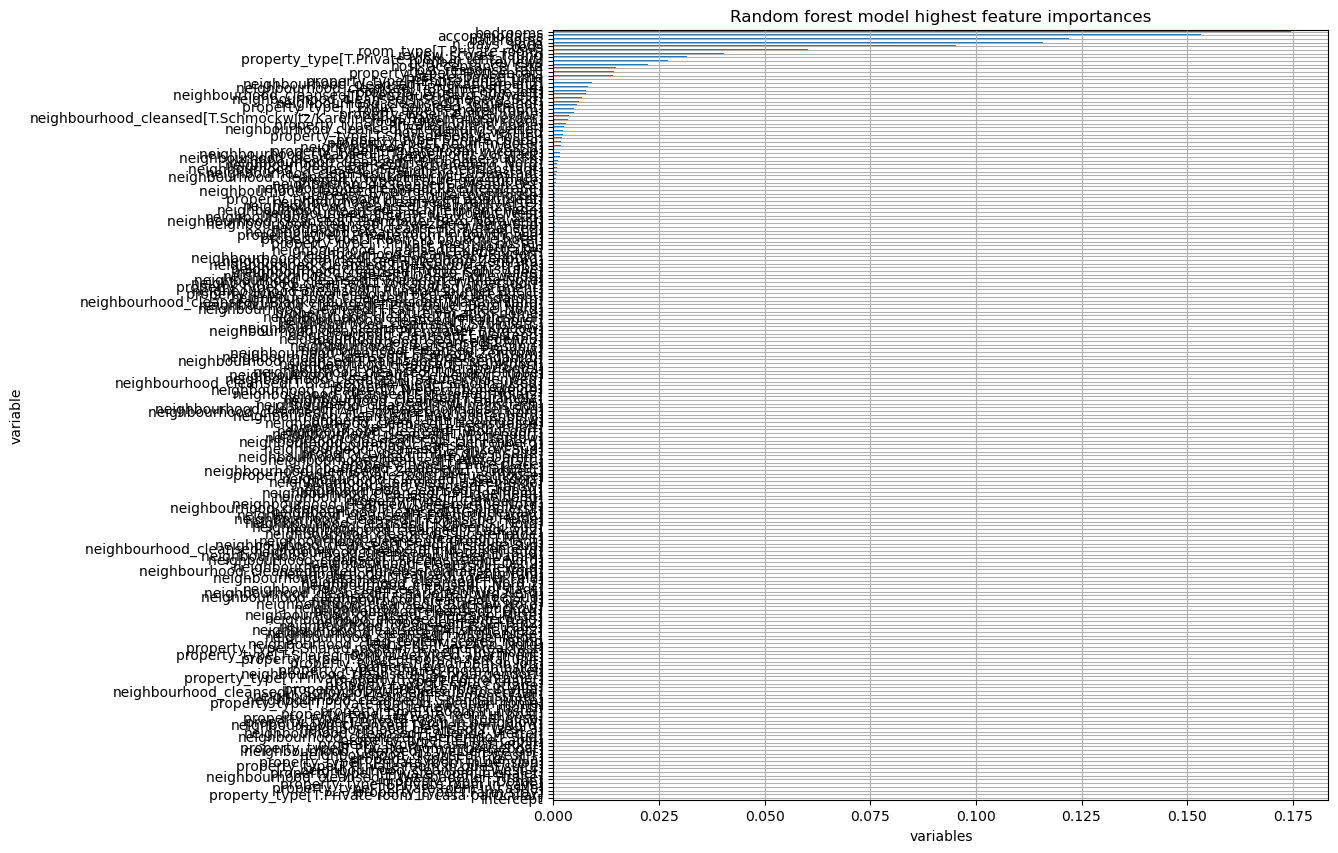

In [144]:
df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

In [145]:
# we only care for variables with an importance of more than 1 pct
cutoff = 0.01

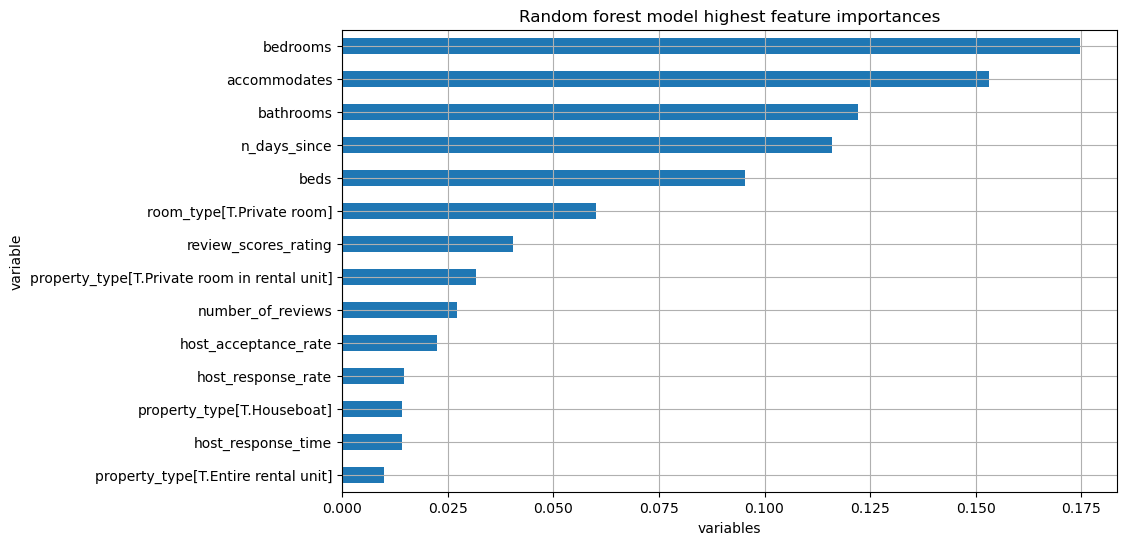

In [146]:
df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

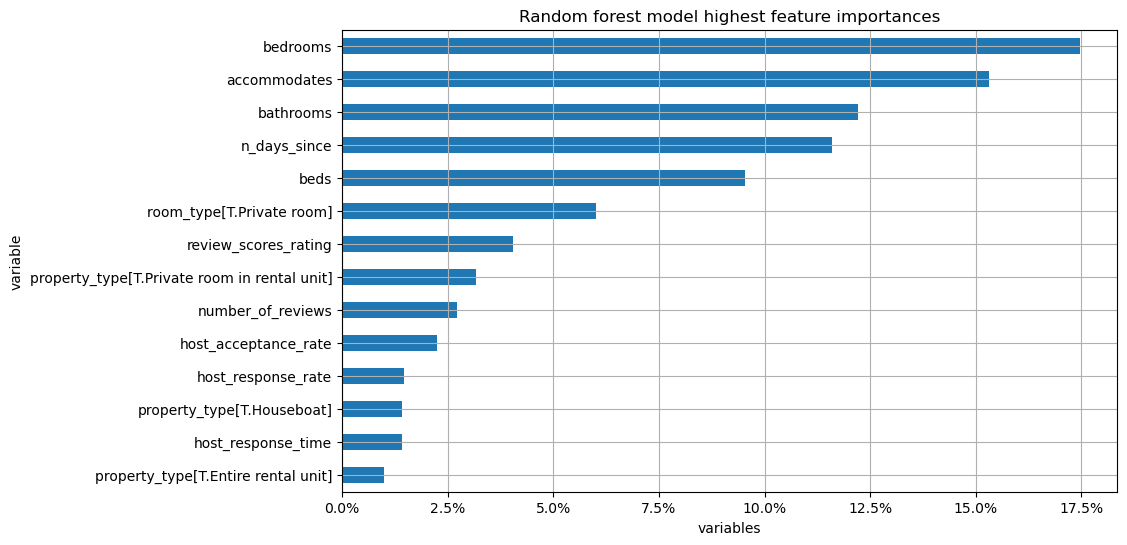

In [147]:
ax = df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh',
          x = 'variable', 
          y = 'imp',
          figsize = (10,6), 
          grid = True,
          title = 'Random forest model highest feature importances',
          xlabel = 'variables', 
          legend = False)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

In [148]:
categorical_columns = [
    "property_type",
    "room_type",
    "neighbourhood_cleansed",
]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [149]:
numerical_columns

['accommodates',
 'beds',
 'n_days_since',
 'bathrooms',
 'bedrooms',
 'number_of_reviews',
 'flag_reviews_per_month',
 'review_scores_rating',
 'flag_review_scores_rating',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'host_identity_verified']

In [150]:
categorical_columns

['property_type', 'room_type', 'neighbourhood_cleansed']

In [151]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [152]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean"))
])

# Create a categorical pipeline using OneHotEncoder (which can handle missing values by ignoring unknowns)
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

# Combine numerical and categorical transformers in a ColumnTransformer
preprocessing = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, numerical_columns),
        ("cat", cat_pipeline, categorical_columns)
    ]
)

# Create the full pipeline, using your best RandomForest model from tuning:
rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessing), 
        ("regressor", rf_model.best_estimator_)  # your tuned RF model
    ]
)

# Fit the pipeline on the training data
rf_pipeline.fit(df_train[predictors_2], df_train.price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['accommodates', 'beds',
                                                   'n_days_since', 'bathrooms',
                                                   'bedrooms',
                                                   'number_of_reviews',
                                                   'flag_reviews_per_month',
                                                   'review_scores_rating',
                                                   'flag_review_scores_rating',
                                                   'host_response_time',
                                                   'host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['property_type', 'room_type',
                                                   'neighbourhood_cleansed'])])),
                ('regressor',
                 RandomForestRegressor(max_features=17, min_samples_leaf=5,
                                       random_state=20250224))])

In [153]:
%%time
result = permutation_importance(
    rf_pipeline,
    df_holdout[predictors_2],
    df_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: user 3.46 s, sys: 59.1 ms, total: 3.52 s
Wall time: 3.61 s


In [154]:
pd.DataFrame(
        result.importances_mean,
        df_train[predictors_2].columns)

,0
accommodates,0.062982
beds,0.016052
n_days_since,0.006409
property_type,0.040775
room_type,0.044692
bathrooms,0.056112
bedrooms,0.034396
neighbourhood_cleansed,0.027570
number_of_reviews,0.007471
flag_reviews_per_month,0.002246


In [155]:
grouped = [
    "property_type",
    "room_type",
    "bathrooms",
    "n_days_since",
    "accommodates",
    "beds",
    "neighbourhood_cleansed",
    "bedrooms",
    'number_of_reviews',
    'review_scores_rating',
    'host_response_rate',
    'host_acceptance_rate',
]

In [156]:
df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        df_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

In [157]:
df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,accommodates,6.3%,6.3%
1,bathrooms,5.6%,11.9%
2,room_type,4.5%,16.4%
3,property_type,4.1%,20.5%
4,bedrooms,3.4%,23.9%
5,neighbourhood_cleansed,2.8%,26.7%
6,review_scores_rating,1.8%,28.5%
7,beds,1.6%,30.1%
8,host_acceptance_rate,0.8%,30.9%
9,number_of_reviews,0.7%,31.7%


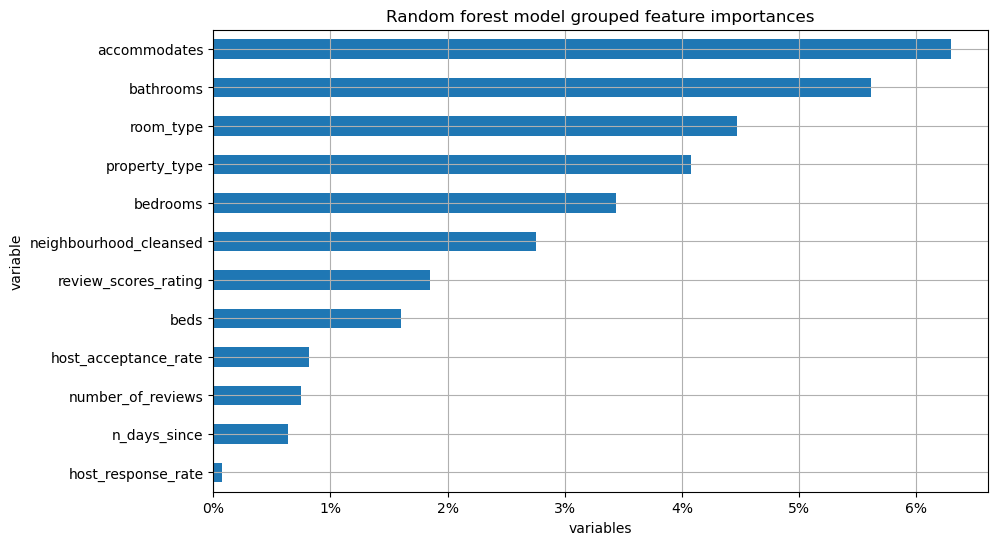

In [158]:
ax = df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         )
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals = 0));

In [159]:
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        df_train[predictors_2].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]

,variable,imp,cumulative_imp
0,accommodates,0.062982,0.174705
1,bathrooms,0.056112,0.327930
2,room_type,0.044692,0.449995
3,property_type,0.040775,0.565973
4,bedrooms,0.034396,0.661340
5,neighbourhood_cleansed,0.027570,0.721548
6,review_scores_rating,0.018495,0.761905
7,beds,0.016052,0.793518
8,host_acceptance_rate,0.008159,0.820703
9,number_of_reviews,0.007471,0.843212


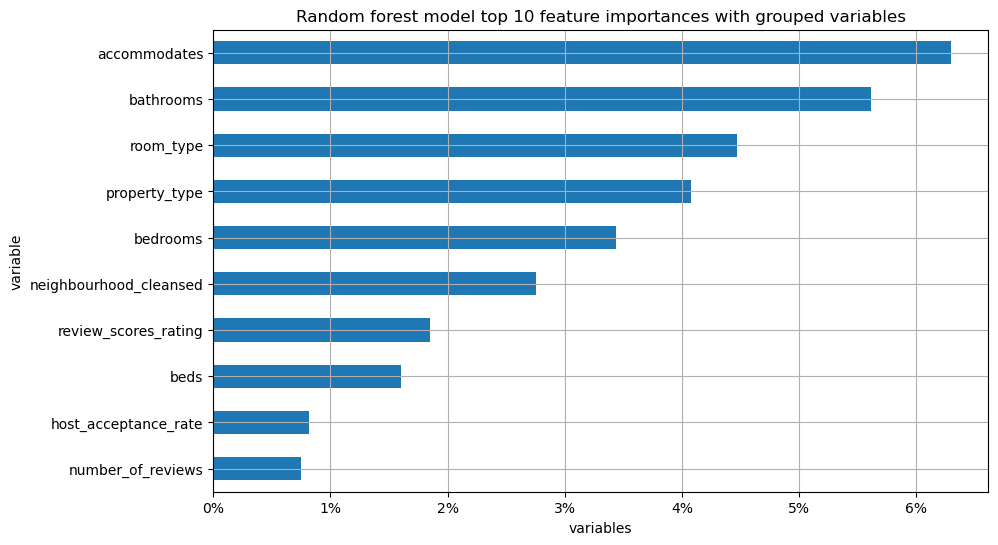

In [160]:
ax = df_clean_varimp.iloc[0:10]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 10 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         )
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals = 0));

In [161]:
accomodates_pdp = partial_dependence(
    rf_pipeline, df_holdout[predictors_2], ["accommodates"], kind="average"
)

In [162]:
accomodates_pdp

{'grid_values': [array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])],
 'average': array([[115.48541742, 119.82453181, 123.69644216, 133.1254268 ,
         147.32555344, 156.96164106, 160.55621243, 167.13042515,
         179.63029732, 183.41479814, 185.98048191, 201.72617651,
         202.77703281, 228.14558712, 275.18942954, 279.51012374]])}

In [163]:
type(accomodates_pdp)

sklearn.utils._bunch.Bunch

In [164]:
pd.DataFrame({
    'number of accommodates': accomodates_pdp['grid_values'][0],
    'average price': accomodates_pdp['average'][0]
})

,number of accommodates,average price
0,1,115.485417
1,2,119.824532
2,3,123.696442
3,4,133.125427
4,5,147.325553
5,6,156.961641
6,7,160.556212
7,8,167.130425
8,9,179.630297
9,10,183.414798


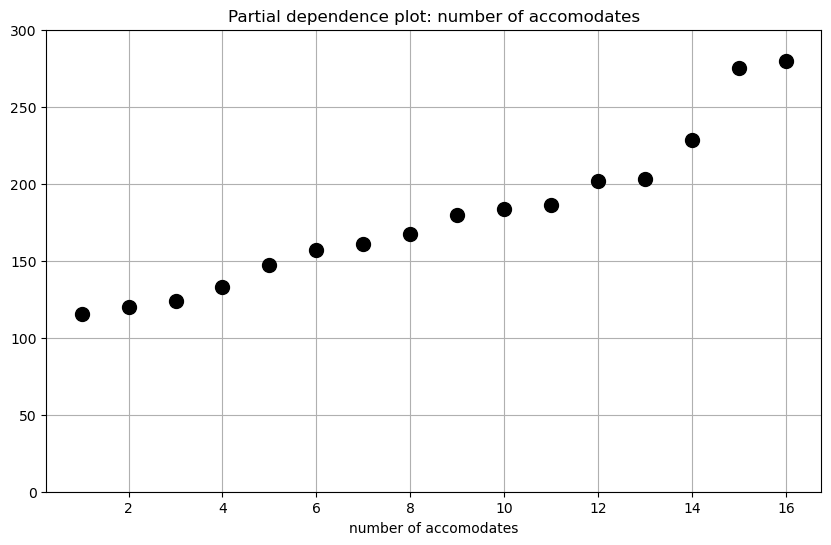

In [165]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['grid_values'][0], 
     'average price': accomodates_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'number of accomodates', y = 'average price', ylim = (0, 300), 
    title = 'Partial dependence plot: number of accomodates'
);

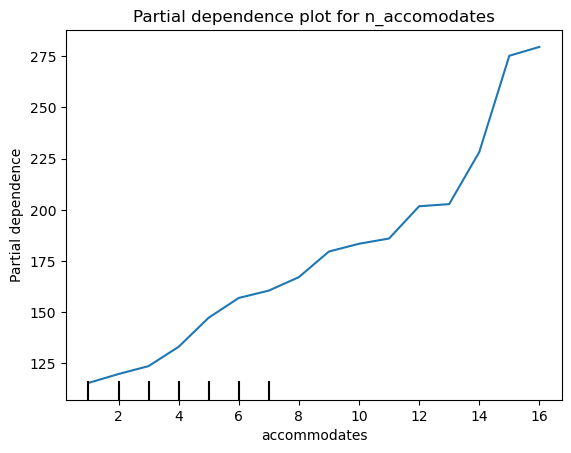

In [166]:
display = PartialDependenceDisplay(
    pd_results = [accomodates_pdp],
    features = [(0,)], 
    feature_names = df_holdout[predictors_2].columns.tolist(), 
    target_idx = 0,
    deciles = {0: np.linspace(1, 7, num=7)}
)
display.plot()
plt.title('Partial dependence plot for n_accomodates')
plt.show();

In [167]:
roomtype_pdp = partial_dependence(
    rf_pipeline, df_holdout[predictors_2], ["room_type"], kind="average"
)

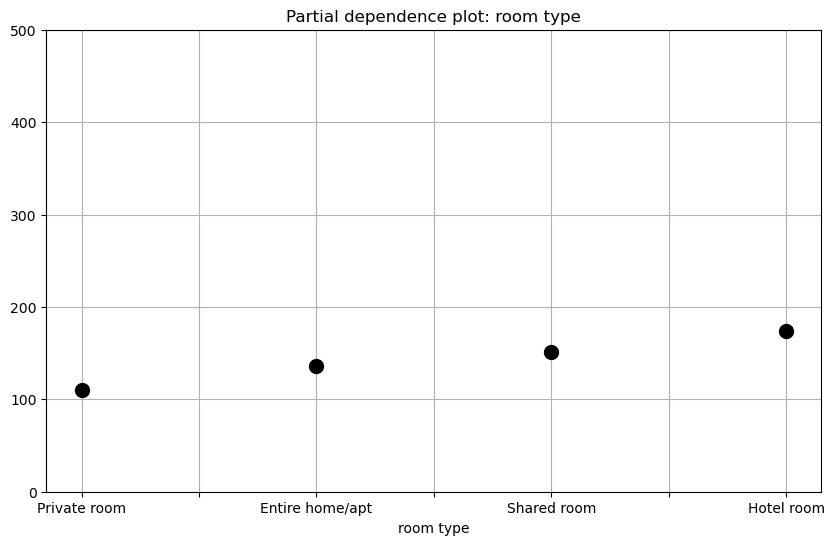

In [168]:
pd.DataFrame(
    {'room type': roomtype_pdp['grid_values'][0], 
     'average price': roomtype_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'room type', y = 'average price', ylim = (0, 500), 
    title = 'Partial dependence plot: room type'
);

In [169]:
df_holdout_w_prediction = df_holdout.assign(
    predicted_price=rf_pipeline.predict(df_holdout[predictors_2])
)

In [170]:
df_holdout_w_prediction['is_low_size'] = df_holdout_w_prediction.accommodates.map(lambda x: 'small apt' if x < 3 else 'large apt')

In [171]:
df_holdout_w_prediction.iloc[0:5, -5:]

,n_accommodates2,n_days_since2,n_days_since3,predicted_price,is_low_size
10324,0,0,0,114.859867,large apt
5580,1,0,0,112.932531,small apt
10220,1,0,0,108.828603,small apt
9650,1,0,0,107.860267,small apt
6479,1,0,0,94.722080,small apt


In [172]:
df_holdout_w_prediction.groupby('is_low_size').apply(lambda x: mean_squared_error(x.predicted_price, x.price, squared=False))

is_low_size
large apt    101.414849
small apt     94.395997
dtype: float64

In [173]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_normalized=lambda x: x.rmse / x.mean_price).round(2)
    )

In [174]:
# cheaper or more expensive flats - not used in book
grouped_object = df_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [175]:
accom_subset

,rmse,mean_price,rmse_normalized
is_low_size,,,
large apt,111.17,180.65,0.62
small apt,89.15,94.95,0.94


In [176]:
unique_neighbourhoods = df['neighbourhood_cleansed'].unique()
print(unique_neighbourhoods)

['Parkviertel' 'nördliche Luisenstadt' 'Alexanderplatz' 'Alt  Treptow'
 'Reuterstraße' 'Prenzlauer Berg Süd' 'Moabit West'
 'Frankfurter Allee Nord' 'Schönholz/Wilhelmsruh/Rosenthal'
 'Schöneberg_Nord' 'Prenzlauer Berg Nord' 'Tempelhof' 'Brunnenstr. Süd'
 'Karl_Marx_Allee_Süd' 'südliche Luisenstadt' 'Kurfürstendamm'
 'Karl_Marx_Allee_Nord' 'Wedding Zentrum' 'Schöneberg_Süd'
 'Regierungsviertel' 'Prenzlauer Berg Südwest' 'Tempelhofer Vorstadt'
 'Tiergarten Süd' 'Prenzlauer Berg Nordwest' 'Moabit Ost'
 'Neue Kantstraße' 'Neuköllner Mitte/Zentrum' 'Frankfurter Allee Süd FK'
 'Albrechtstr.' 'Oberschöneweide' 'Friedrichshagen' 'Otto_Suhr_Allee'
 'Buckow' 'Mariendorf' 'Mierendorffplatz' 'Wilhelmstadt' 'Halensee'
 'Adlershof' 'Neu Lichtenberg' 'Drakestr.' 'Schmargendorf'
 'Falkenhagener Feld' 'Westend' 'Brunsbütteler Damm' 'Ost 2' 'Britz'
 'Heerstrasse' 'Barstraße' 'Friedenau' 'Düsseldorfer Straße'
 'Zehlendorf  Südwest' 'Alt_Hohenschönhausen Süd' 'Baumschulenweg'
 'Altstadt_Kietz' 'Fennpfuhl

In [177]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            df_holdout_w_prediction.price,
            df_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        df_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_normalized=lambda x: x.rmse / x.mean_price).round(2)
all_holdout.index = ["Total"]

all_holdout.style.format({'rmse': '{:.1f}', 'mean_price': '{:.1f}', 'rmse_normalized': '{:.2f}'})

,rmse,mean_price,rmse_normalized
Total,97.8,126.5,0.77


## CART

In [178]:
from sklearn.tree import DecisionTreeRegressor

In [179]:
y, X = patsy.dmatrices("price ~ " + " + ".join(predictors_2), df_train, return_type='dataframe')

In [180]:
X.shape

(4810, 209)

In [181]:
cart_model = DecisionTreeRegressor(random_state=20250224)

In [182]:
path = cart_model.cost_complexity_pruning_path(X, y.values.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [183]:
ccp_alphas

array([0.00000000e+00, 6.93000693e-05, 1.03950104e-04, ...,
       1.02704617e+03, 1.47585287e+03, 2.41195466e+03])

In [184]:
ccp_alphas.shape

(3904,)

In [185]:
impurities

array([0.00000000e+00, 1.38600139e-04, 2.42550243e-04, ...,
       1.30777127e+04, 1.45535656e+04, 1.69655202e+04])

In [186]:
%%time

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv = 5,
    scoring="neg_root_mean_squared_error",
    verbose = 3,
)
cart_model_cv.fit(X, y.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ccp_alpha=0.00010395010395010396;, score=-191.615 total time=   0.1s
[CV 2/5] END ccp_alpha=0.00010395010395010396;, score=-112.761 total time=   0.0s
[CV 3/5] END ccp_alpha=0.00010395010395010396;, score=-131.160 total time=   0.0s
[CV 4/5] END ccp_alpha=0.00010395010395010396;, score=-150.506 total time=   0.0s
[CV 5/5] END ccp_alpha=0.00010395010395010396;, score=-130.480 total time=   0.0s
[CV 1/5] END ..ccp_alpha=0.17963270963271066;, score=-191.561 total time=   0.1s
[CV 2/5] END ..ccp_alpha=0.17963270963271066;, score=-112.513 total time=   0.1s
[CV 3/5] END ..ccp_alpha=0.17963270963271066;, score=-130.919 total time=   0.1s
[CV 4/5] END ..ccp_alpha=0.17963270963271066;, score=-150.218 total time=   0.1s
[CV 5/5] END ..ccp_alpha=0.17963270963271066;, score=-130.557 total time=   0.1s
[CV 1/5] END ..ccp_alpha=0.11387849387849691;, score=-191.532 total time=   0.1s
[CV 2/5] END ..ccp_alpha=0.1138784938784969

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=20250224),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 6.93000693e-05, 1.03950104e-04, ...,
       1.02704617e+03, 1.47585287e+03, 2.41195466e+03])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [187]:
best_cart = cart_model_cv.best_estimator_

In [188]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
cart_rmse

133.70241780528548

In [189]:
y_train_pred = best_cart.predict(X)
rmse_cart_train = np.sqrt(mean_squared_error(y, y_train_pred))
print(f"Training RMSE: {rmse_cart_train:.3f}")

# --- Compute Holdout RMSE ---
# Assume you have a holdout set with design matrices built the same way as X.
# For example, using:
# y_holdout, X_holdout = dmatrices("price ~ " + " + ".join(predictors_2), df_holdout, return_type='dataframe')
# And ensuring that X_holdout is reindexed to have the same columns as X.
y_holdout, X_holdout = dmatrices("price ~ " + " + ".join(predictors_2), df_holdout, return_type='dataframe')
X_holdout = X_holdout.reindex(columns=X.columns, fill_value=0)

y_holdout_pred = best_cart.predict(X_holdout)
rmse_cart_holdout = np.sqrt(mean_squared_error(y_holdout, y_holdout_pred))
print(f"Holdout RMSE: {rmse_cart_holdout:.3f}")

Training RMSE: 71.483
Holdout RMSE: 95.463


## GBM Boosting

In [190]:
from sklearn.ensemble import GradientBoostingRegressor

In [191]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 10
                                #, n_estimators = 50
                               )

tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [192]:
categorical_columns = [
    'property_type',
    'room_type',
    'neighbourhood_cleansed'
]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [193]:
tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features=10, random_state=42)
gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

# Define categorical and numerical columns:
categorical_columns = [
    'property_type',
    'room_type',
    'neighbourhood_cleansed'
]
# predictors_2 should already be defined; now numerical_columns are those in predictors_2 not in categorical_columns.
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

# Create a numerical pipeline that imputes missing values:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean"))
])

# Create a categorical pipeline:
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

# Combine them with ColumnTransformer:
preprocessing = ColumnTransformer(
    transformers=[
        ("cat", cat_pipeline, categorical_columns),
        ("num", num_pipeline, numerical_columns),
    ]
)

# Build the complete pipeline with boosting:
gbm_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessing),
        ("regressor", gbm_model_cv)
    ],
    verbose=True
)

# Fit the pipeline on your training data:
gbm_pipe.fit(df_train[list(predictors_2)], df_train.price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 2/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 1/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 3/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 4/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 1/5; 2/4] START max_depth=5, n_estimators=300...............................
[CV 2/5; 2/4] START max_depth=5, n_estimators=300...............................
[CV 5/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 3/5; 2/4] START max_depth=5, n_estimators=300...............................
[CV 3/5; 1/4] END max_depth=5, n_estimators=200;, score=-126.576 total time=   0.3s
[CV 1/5; 1/4] END max_depth=5, n_estimators=200;, score=-130.764 total time=   0.4s
[CV 4/5; 2/4] START max_depth=5, n_estimators=300....

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['property_type', 'room_type',
                                                   'neighbourhood_cleansed']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['accommodates', 'beds',
                                                   'n_days_since', 'bathrooms',
                                                   'bedrooms',
                                                   'number_of_reviews',
                                                   'flag_reviews_per_month...
                                                   'host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(max_features=10,
                                                                  min_samples_split=20,
                                                                  random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10],
                                          'n_estimators': [200, 300]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [194]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(max_depth=10, max_features=10, min_samples_split=20,
                          n_estimators=200, random_state=42)

In [195]:
gbm_rmse = gbm_model_cv.best_score_*-1

In [196]:
gbm_rmse

106.35000659588385

In [197]:
y_train_pred = gbm_pipe.predict(df_train[list(predictors_2)])
rmse_gbm_train = np.sqrt(mean_squared_error(df_train.price, y_train_pred))
print(f"GBM Train RMSE: {rmse_gbm_train:.3f}")

# Predict on the holdout set using the pipeline
y_holdout_pred = gbm_pipe.predict(df_holdout[list(predictors_2)])
rmse_gbm_holdout = np.sqrt(mean_squared_error(df_holdout.price, y_holdout_pred))
print(f"GBM Holdout RMSE: {rmse_gbm_holdout:.3f}")

GBM Train RMSE: 49.402
GBM Holdout RMSE: 96.051


## MLP Regressor

In [198]:
from sklearn.neural_network import MLPRegressor

# Initialize and train MLP Neural Network
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1500, random_state=20250301)
mlp_model.fit(X, y)

# Predictions & RMSE
y_pred_mlp = mlp_model.predict(X)
mlp_train_rmse = np.sqrt(mean_squared_error(y, y_pred_mlp))

print("MLP Neural Network RMSE:", mlp_train_rmse)

MLP Neural Network RMSE: 104.9743778653362


In [199]:
y_h, X_holdout = patsy.dmatrices("price ~ " + " + ".join(predictors_2), df_holdout, return_type='dataframe')
X_holdout = X_holdout.reindex(columns=X.columns, fill_value=0)

In [200]:
y_pred_mlp_holdout = mlp_model.predict(X_holdout)
mlp_rmse_holdout = np.sqrt(mean_squared_error(y_h, y_pred_mlp_holdout))
print(f"MLP Holdout RMSE: {mlp_rmse_holdout:.3f}")

MLP Holdout RMSE: 73.577


## Cat Boost Regressor

In [201]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Assume 'df' is your cleaned DataFrame and predictors_2 is defined as:
# (basic_vars + reviews + host + amenities)
# and categorical_columns is defined as:
# ['property_type', 'room_type', 'neighbourhood_cleansed']

# For CatBoost, we want the categorical features as strings.
df_cat = df.copy()
for col in ['property_type', 'room_type', 'neighbourhood_cleansed']:
    df_cat[col] = df_cat[col].astype(str)

# Define X and y
X = df_cat[predictors_2]
y = df_cat['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical feature indices (CatBoost accepts these indices directly)
# predictors_2 should be the full list of predictor column names.
cat_features = [i for i, col in enumerate(predictors_2) if col in ['property_type', 'room_type', 'neighbourhood_cleansed']]

# Initialize and train CatBoostRegressor
catboost_model = CatBoostRegressor(
    iterations=500,       # you can tune this
    learning_rate=0.1,      # you can tune this
    depth=6,                # you can tune this
    random_seed=42,
    verbose=100             # shows progress every 100 iterations
)

# Fit the model, specifying which features are categorical
catboost_model.fit(X_train, y_train, cat_features=cat_features)

# Predict on the test set
y_pred = catboost_model.predict(X_test)

# Calculate RMSE
CatBootrmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("CatBoost RMSE:", rmse)

0:	learn: 129.7592348	total: 65.4ms	remaining: 32.6s
100:	learn: 82.4200102	total: 311ms	remaining: 1.23s
200:	learn: 71.2439209	total: 531ms	remaining: 790ms
300:	learn: 62.7421540	total: 761ms	remaining: 503ms
400:	learn: 58.3114260	total: 1.01s	remaining: 249ms
499:	learn: 54.5256577	total: 1.24s	remaining: 0us
CatBoost RMSE: <function rmse at 0x15e4dcf40>


In [202]:
# Predict on the training set
y_pred_train = catboost_model.predict(X_train)

# Calculate RMSE for the training set
catboot_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("CatBoost Training RMSE:", catboot_rmse_train)

CatBoost Training RMSE: 63.41387415077819


In [203]:
X_holdout = df_holdout[predictors_2]
y_holdout = df_holdout["price"]

# Predict using your fitted CatBoost model
y_holdout_pred = catboost_model.predict(X_holdout)

# Calculate RMSE on the holdout data
catboot_holdout_rmse = np.sqrt(mean_squared_error(y_holdout, y_holdout_pred))
print("Holdout RMSE:", catboot_holdout_rmse)

Holdout RMSE: 69.14506374835948


                      Feature  Importance
0                accommodates   16.248918
2                n_days_since   13.059139
7      neighbourhood_cleansed   12.475301
3               property_type    9.330592
6                    bedrooms    8.947598
4                   room_type    8.411680
5                   bathrooms    7.976024
14       host_acceptance_rate    6.084208
10       review_scores_rating    4.658032
1                        beds    4.479596
8           number_of_reviews    3.118932
12         host_response_time    2.255648
13         host_response_rate    1.814065
16     host_identity_verified    0.559033
11  flag_review_scores_rating    0.288267
9      flag_reviews_per_month    0.256954
15       host_has_profile_pic    0.036012


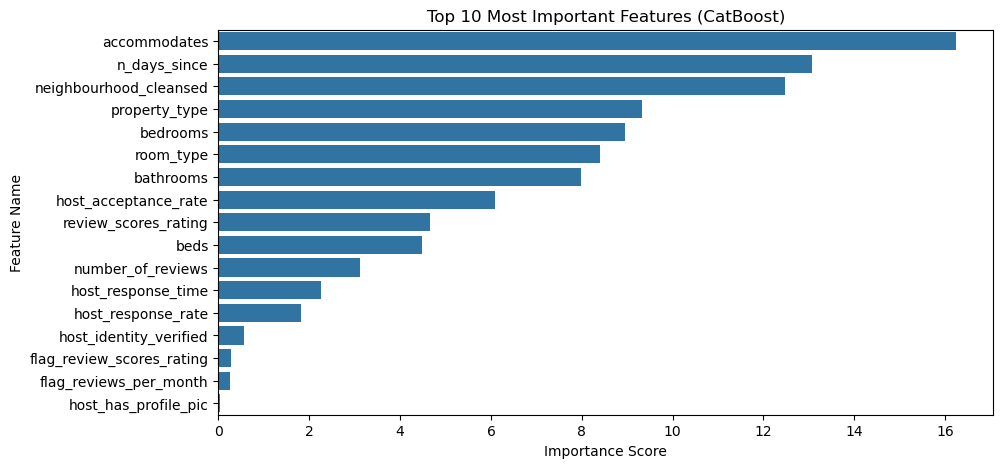

In [208]:
feature_importance = catboost_model.get_feature_importance()
feature_names = X_train.columns

# Create a DataFrame for sorting and visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)  # Get top 10

# Display the top 10 features
print(importance_df)

# Plot the feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Top 10 Most Important Features (CatBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()

## Results

In [204]:
rmse_results = pd.DataFrame({
    "Model": [
        "OLS", 
        "Lasso", 
        "Lasso (GridSearchCV)",
        "Random Forest",
        "CART",
        "GBM Boosting",
        "MLP Regressor",
        "CatBoost Regressor"
    ],
    "Training RMSE": [
        model2_train_rmse,         # OLS training RMSE
        rmse_Lasso_train,          # Lasso training RMSE
        model7_level_work_rmse,    # Lasso (GridSearchCV) training RMSE
        rmse_rf_train,             # Random Forest training RMSE
        rmse_cart_train,           # CART training RMSE
        rmse_gbm_train,            # GBM training RMSE
        mlp_train_rmse,             # MLP training RMSE
        catboot_rmse_train         # CatBoost training RMSE
    ],
    "Holdout RMSE": [
        model2_test_rmse,          # OLS test RMSE from CV folds
        rmse_Lasso_test,           # Lasso test RMSE
        model7_level_holdout_rmse, # Lasso (GridSearchCV) holdout RMSE
        rmse_rf_hold,             # Random Forest holdout RMSE
        rmse_cart_holdout,         # CART holdout RMSE
        rmse_gbm_holdout,          # GBM holdout RMSE
        mlp_rmse_holdout,          # MLP holdout RMSE
        catboot_holdout_rmse       # CatBoost holdout RMSE
    ]
})

# Print the results table
print(rmse_results)

                  Model  Training RMSE  Holdout RMSE
0                   OLS      98.745369    100.769354
1                 Lasso      90.451556    104.392934
2  Lasso (GridSearchCV)     104.909784     80.263696
3         Random Forest      99.815209     72.134838
4                  CART      71.483451     95.462548
5          GBM Boosting      49.401853     96.051158
6         MLP Regressor     104.974378     73.577356
7    CatBoost Regressor      63.413874     69.145064


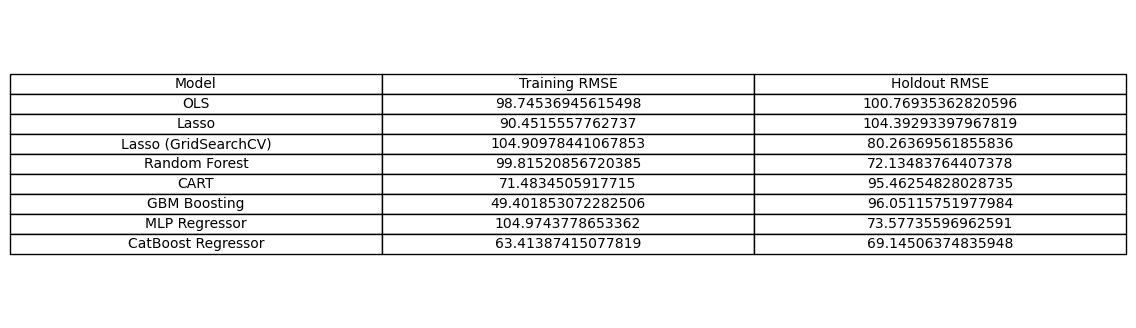

In [205]:
fig, ax = plt.subplots(figsize=(12, 4))  # adjust the size as needed

# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create a table from the DataFrame
table = ax.table(
    cellText=rmse_results.values,
    colLabels=rmse_results.columns,
    cellLoc='center',
    loc='center'
)

# Optionally, adjust the table properties for a better look:
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Save the figure as an image file
plt.savefig("rmse_results_table.png", bbox_inches='tight', dpi=300)
plt.show()

# The Best Method CatBoost Regressor